In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import igviz as ig
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import seaborn as sns
import matplotlib.pyplot as plt
# import src.visualize as vis
# from src.visualize import visualize_celllevel_graph
# # import sys
# sys.path.append('./src/')
# sys.path.append('./src/submodules/CeSpGRN/src/')
# from src.preprocessing import construct_celllevel_graph
from plotly.subplots import make_subplots
# from src import models, training
# from torch_geometric.nn import GAE
import torch
import os
raw_data_path = "./data/"
starting_df = pd.read_csv(os.path.join(raw_data_path,f"star_dataframe.csv"))

In [2]:
from rich.progress import track
from rich.table import Table
from rich.console import Console
import random
import sys
from node2vec import Node2Vec
import os

In [3]:
def visualize_celllevel_graph(df, title, edge_trace=None, edge_weights=1, publication=False):
    # Convert pixels to inches (for 100 DPI, 700px becomes 7 inches, 650px becomes 6.5 inches)
    figsize_in_inches = (700 / 100, 650 / 100)  # 700x650 pixels at 100 DPI
    
    # 创建一个新图形，设置大小为700x650像素（100 DPI）
    fig, ax = plt.subplots(figsize=figsize_in_inches)

    # 绘制细胞散点图，所有点的颜色统一为灰色
    ax.scatter(df["X"], df["Y"], color="gray", s=6, alpha=0.8, label="Cells")

    # 如果有边的坐标信息，添加边的描绘
    if edge_trace is not None:
        for i in range(0, len(edge_trace[0]), 2):
            x0, y0 = edge_trace[0][i], edge_trace[1][i]
            x1, y1 = edge_trace[0][i+1], edge_trace[1][i+1]
            ax.plot([x0, x1], [y0, y1], color='#888', lw=1.1, alpha=0.7)

    # 设置标题
    ax.set_title(title, fontsize=16, family="Times New Roman", color="black")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")

    # 设置坐标轴样式
    ax.tick_params(axis='both', which='both', length=5, width=1, labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 设置出版风格的布局（清晰的白色背景，简洁的线条，去除不必要的元素）
    if not publication:
        ax.grid(False)  # 隐藏网格线

    # 如果需要出版风格，设置白色背景和没有图例
    else:
        ax.set_facecolor("white")
        ax.legend().set_visible(False)
    return fig

In [3]:
# def construct_celllevel_graph(data_df, k, get_edges=False):   # Top k closest neighbors for each cell
#     '''
#     Constructs new cell graph with spatial proximity edges based on kNN.
    
#     :data_df: pd.DataFrame : represents the spatial data and contains the following columns ["Cell_ID", "X", "Y"]
#     :k: int: Number of nearest neighbors to construct spatial edges for
#     :get_edges: boolean:  True to return edge_trace (for visualization purposes)
    
#     :return: Cell_level_adjacency, edge list
#     '''
    
#     adjacency = np.zeros(shape=(len(data_df), k),dtype=int) # shape = (numcells, numneighbors of cell)
#     coords = np.vstack([data_df["X"].values,data_df["Y"].values]).T

#     edges = None
#     edge_x = []
#     edge_y = []

#     # for i in tqdm(range(len(data_df)), desc=f"2. Constructing Cell-Level Graph from ST Data", colour="cyan", position=1):
#     for i in track(range(len(data_df)), description=f"[cyan]2. Constructing Cell-Level Graph from ST Data"):
#         cell_id = data_df["Cell_ID"][i]
#         x0, y0 = data_df["X"].values[i],data_df["Y"].values[i]
#         candidate_cell = coords[i]
#         candidate_neighbors = coords
#         euclidean_distances = np.linalg.norm(candidate_neighbors - candidate_cell,axis=1)
#         neighbors = np.argsort(euclidean_distances)[1:k+1]
#         adjacency[i] = neighbors
#         assert i not in adjacency[i]
#         if get_edges:
#             for ncell in adjacency[i]:
#                 x1, y1 = data_df["X"].values[ncell],data_df["Y"].values[ncell]
#                 edge_x.append(x0)
#                 edge_x.append(x1)
#                 edge_x.append(None)
#                 edge_y.append(y0)
#                 edge_y.append(y1)
#                 edge_y.append(None)
        
#     edges=[edge_x,edge_y]
                
#     return adjacency,edges

In [ ]:
# import numpy as np

# def construct_celllevel_graph_with_spatial_threshold_and_strength(data_df, k, sigma=70, get_edges=False):
#     '''
#     基于欧氏距离构建细胞图，并根据空间距离计算边的强度。
#     直接选择最近的 k 个细胞，并使用高斯核函数计算边的权重（强度）。

#     :data_df: pd.DataFrame : 包含空间数据，包含 ["Cell_ID", "X", "Y"]
#     :k: int : 每个细胞的邻居数量
#     :sigma: float : 高斯核的标准差（用于计算边的强度）
#     :get_edges: boolean : 如果为True，返回边坐标和边权重（用于可视化）

#     :return: adjacency, edges, edge_weights, network_relationship
#     '''

#     # 初始化邻接矩阵（大小为 num_cells x num_cells，所有值初始化为 0）
#     num_cells = len(data_df)
#     #adjacency = np.zeros(shape=(num_cells, num_cells), dtype=float)  
#     coords = np.vstack([data_df["X"].values, data_df["Y"].values]).T  # 存储所有细胞的坐标
#     adjacency = np.zeros(shape=(len(data_df), k),dtype=int)
#     # 初始化边坐标和边权重列表
#     edges = None
#     edge_x = []
#     edge_y = []
#     edge_weights = []  # 用于存储每条边的权重（强度）

#     # 初始化网络关系矩阵（初始为零）
#     network_relationship = np.zeros((len(data_df), len(data_df)))

#     for i in range(len(data_df)):  # 遍历每个细胞
#         cell_id = data_df["Cell_ID"][i]
#         x0, y0 = data_df["X"].values[i], data_df["Y"].values[i]
#         candidate_cell = coords[i]
#         candidate_neighbors = coords
#         euclidean_distances = np.linalg.norm(candidate_neighbors - candidate_cell, axis=1)  # 计算欧氏距离

#         # 步骤 1：按欧氏距离升序排序（不包括自己），找到最接近的细胞
#         sorted_indices = np.argsort(euclidean_distances)[1:]  # 排序并排除自己（距离自己为0）
        
#         # 步骤 2：选择前 k 个邻居（不使用 tau 限制）
#         valid_neighbors = sorted_indices[:k]  # 直接选择前 k 个最接近的邻居
        
#         # 步骤 3：填充邻接矩阵（使用 1 表示连接）
#         for ncell in valid_neighbors:
#             distance = euclidean_distances[ncell]
#             strength = np.exp(- (distance ** 2) / (2 * sigma ** 2))  # 基于高斯核计算边的强度（根据距离）

#             # 归一化关系强度到 [0, 1] 范围
#             normalized_strength = strength  # 直接使用计算的强度，不需要归一化

#             # 更新网络关系矩阵（关系强度）
#             network_relationship[i, ncell] = normalized_strength
#             network_relationship[ncell, i] = normalized_strength  # 对称关系
#             #adjacency[i] = valid_neighbors
#             adjacency[i, :] = valid_neighbors
#             assert i not in adjacency[i]
#             # 获取边的坐标（用于可视化）
#             if get_edges:
#                 for ncell in adjacency[i]:
#                     x1, y1 = data_df["X"].values[ncell], data_df["Y"].values[ncell]
#                     edge_x.append(x0)
#                     edge_x.append(x1)
#                     edge_y.append(y0)
#                     edge_y.append(y1)
#                     edge_weights.append(strength)  # 存储每条边的权重

#     # 返回邻接矩阵、边坐标、边权重和网络关系矩阵
#     edges = [edge_x, edge_y] if get_edges else None
#     return adjacency, edges, edge_weights, network_relationship
# celllevel_adj1, edges1, edge_weights1,network_relationship1 = construct_celllevel_graph_with_spatial_threshold_and_strength(
#     starting_df, k=2, sigma=50, get_edges=True
# )

# # 使用可视化函数显示结果
# sim_fig = visualize_celllevel_graph(
#     starting_df, title="Cell_Interaction(Spatial)", edge_trace=edges1, edge_weights=edge_weights1, publication=True
# )

In [ ]:
##########距离的

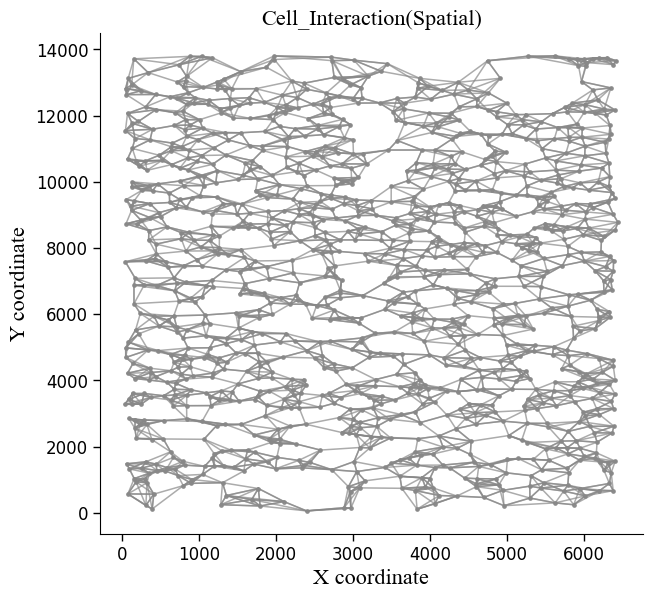

In [26]:


def visualize_celllevel_graph(df, title, edge_trace=None, edge_weights=1, publication=False):
    # Convert pixels to inches (for 100 DPI, 700px becomes 7 inches, 650px becomes 6.5 inches)
    figsize_in_inches = (700 / 100, 650 / 100)  # 700x650 pixels at 100 DPI
    
    # 创建一个新图形，设置大小为700x650像素（100 DPI）
    fig, ax = plt.subplots(figsize=figsize_in_inches)

    # 绘制细胞散点图，所有点的颜色统一为灰色
    ax.scatter(df["X"], df["Y"], color="gray", s=6, alpha=0.8, label="Cells")

    # 如果有边的坐标信息，添加边的描绘
    if edge_trace is not None:
        for i in range(0, len(edge_trace[0]), 2):
            x0, y0 = edge_trace[0][i], edge_trace[1][i]
            x1, y1 = edge_trace[0][i+1], edge_trace[1][i+1]
            ax.plot([x0, x1], [y0, y1], color='#888', lw=1.1, alpha=0.7)

    # 设置标题
    ax.set_title(title, fontsize=16, family="Times New Roman", color="black")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")

    # 设置坐标轴样式
    ax.tick_params(axis='both', which='both', length=5, width=1, labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 设置出版风格的布局（清晰的白色背景，简洁的线条，去除不必要的元素）
    if not publication:
        ax.grid(False)  # 隐藏网格线

    # 如果需要出版风格，设置白色背景和没有图例
    else:
        ax.set_facecolor("white")
        ax.legend().set_visible(False)

#     # 保存图像，增加DPI以提高分辨率
#     plt.tight_layout()  # 自动调整布局
#     plt.savefig("Cell_Interaction(Distance_based)_seq.png", dpi=300, bbox_inches='tight')  # 保存为高分辨率图像

    return fig
import numpy as np

def construct_celllevel_graph_with_spatial_threshold_and_strength(data_df, k, tau=0.5, sigma=70, get_edges=False):
    '''
    Constructs a new cell graph with spatial proximity edges based on Euclidean distance and a spatial threshold.
    Also adds relationship strength based on spatial distance.

    :data_df: pd.DataFrame : represents the spatial data and contains the following columns ["Cell_ID", "X", "Y"]
    :k: int : Number of nearest neighbors to construct spatial edges for
    :tau: float : Threshold for the spatial distance to define biologically meaningful interactions
    :sigma: float : Standard deviation for Gaussian kernel (for strength calculation)
    :get_edges: boolean : True to return edge_trace (for visualization purposes)

    :return: Cell_level_adjacency, edge list, edge weights, network_relationship
    '''

    # Initialize adjacency matrix and edge lists
    num_cells = len(data_df)
    adjacency = np.zeros(shape=(num_cells,k), dtype=int)  # shape = (num_cells, num_neighbors)
    coords = np.vstack([data_df["X"].values, data_df["Y"].values]).T  # Cell coordinates

    edges = None
    edge_x = []
    edge_y = []
    edge_weights = []  # To store the strength of each edge

    # Initialize network relationship matrix (all zeros initially)
    network_relationship = np.zeros((len(data_df), len(data_df)))

    for i in range(len(data_df)):  # Loop through each cell
        x0, y0 = data_df["X"].values[i], data_df["Y"].values[i]
        candidate_cell = coords[i]
        candidate_neighbors = coords
        euclidean_distances = np.linalg.norm(candidate_neighbors - candidate_cell, axis=1)

        # Step 1: Sort cells based on Euclidean distances in ascending order (ignore self)
        sorted_indices = np.argsort(euclidean_distances)[1:]  # Sort by distance (ascending), excluding self
        
        # Step 2: Apply threshold tau and select up to k neighbors
        valid_neighbors = [idx for idx in sorted_indices if euclidean_distances[idx]][:k]
        
        # Fill adjacency list with valid neighbors
        adjacency[i, :len(valid_neighbors)] = valid_neighbors
        
        if get_edges:
            for ncell in valid_neighbors:
                x1, y1 = data_df["X"].values[ncell], data_df["Y"].values[ncell]
                # Calculate Gaussian kernel-based edge strength based on spatial distance
                distance = euclidean_distances[ncell]
                strength = np.exp(- (distance ** 2) / (2 * sigma ** 2))  # Gaussian kernel for distance-based strength
                edge_weights.append(strength)
                
                # Update the network relationship matrix with strength values
                network_relationship[i, ncell] = strength
                network_relationship[ncell, i] = strength  # Symmetric matrix

                # Add edge coordinates for visualization
                edge_x.append(x0)
                edge_x.append(x1)
                #edge_x.append(None)
                edge_y.append(y0)
                edge_y.append(y1)
                #edge_y.append(None)

    # Return adjacency matrix, edge list, edge weights, and network relationship matrix
    edges = [edge_x, edge_y] if get_edges else None

    return adjacency, edges, edge_weights, network_relationship

celllevel_adj1, edges1, edge_weights1,network_relationship1 = construct_celllevel_graph_with_spatial_threshold_and_strength(
    starting_df, k=5, tau=5, sigma=100, get_edges=True
)
# 使用可视化函数显示结果
sim_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(Spatial)", edge_trace=edges1, edge_weights=edge_weights1, publication=True
)




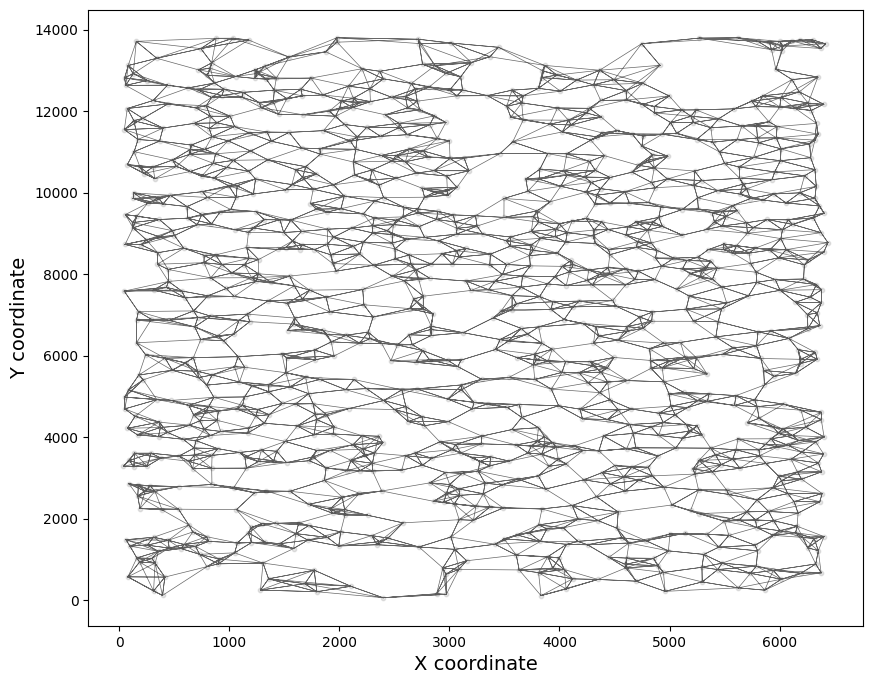

In [5]:
def visualize_graph_from_edges(data_df, unique_edges, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    
    all_cells_x = data_df['X'].values
    all_cells_y = data_df['Y'].values

    ax.scatter(all_cells_x, all_cells_y, s=10, color='gray', alpha=0.2, label="Background Cells")

    edge_x = []
    edge_y = []
    
    # 检查unique_edges的形状，假设为[2, N]
    if unique_edges.shape[0] != 2:
        raise ValueError("unique_edges should have shape [2, N]")
    
    num_edges = unique_edges.shape[1]
    
    for i in range(num_edges):
        source = unique_edges[0, i].item()  # 转换为Python整数
        target = unique_edges[1, i].item()
        
        if source >= len(data_df) or target >= len(data_df):
            print(f"Skipping invalid edge: {source} -> {target}")
            continue
        
        x0, y0 = data_df.loc[source, "X"], data_df.loc[source, "Y"]
        x1, y1 = data_df.loc[target, "X"], data_df.loc[target, "Y"]
        
        edge_x.extend([x0, x1, None])  # 添加None分隔线段
        edge_y.extend([y0, y1, None])
    
    # 绘制边
    ax.plot(edge_x, edge_y, color='black', linewidth=0.5, alpha=0.6)
    
    ax.set_xlabel("X coordinate", fontsize=14)
    ax.set_ylabel("Y coordinate", fontsize=14)
    ax.tick_params
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    edge_list = []
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
    return np.array(edge_list).T
celllevel_edgelist1 =convert_adjacencylist2edgelist(celllevel_adj1)
visualize_graph_from_edges(starting_df, celllevel_edgelist1, figsize=(10, 8))

In [6]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist1 =convert_adjacencylist2edgelist(celllevel_adj1)
assert celllevel_edgelist1.shape == (2, celllevel_adj1.shape[0] * celllevel_adj1.shape[1])


In [7]:
celllevel_edgelist1.shape

(2, 6035)

In [ ]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist1 =convert_adjacencylist2edgelist(celllevel_adj1)
assert celllevel_edgelist1.shape == (2, celllevel_adj1.shape[0] * celllevel_adj1.shape[1])


In [5]:
def normalize_network_relationship(network_relationship):
    # 获取最小值和最大值
    min_val = np.min(network_relationship)
    max_val = np.max(network_relationship)
    
    # 执行最大-最小归一化
    normalized_network_relationship = (network_relationship - min_val) / (max_val - min_val)
    
    return normalized_network_relationship

# 对 network_relationship 进行归一化
network_relationship1 = normalize_network_relationship(network_relationship1)


In [18]:
network_relationship3 = normalize_network_relationship(network_relationship3)

In [ ]:
##################配受体

In [27]:
import numpy as np
import scipy.sparse as sp

def construct_celllevel_graph_top_edges(data_df, ligand_receptor_pairs, threshold=0.01, sigma=800, k=5, get_edges=True):
    """
    优化版本：基于配体-受体表达和空间距离构建细胞图，正确存储邻居矩阵和边权重
    
    改进点：
    1. 使用稀疏矩阵存储邻接矩阵
    2. 仅记录有效边，避免存储过多的零
    3. 优化存储边的坐标和权重
    """
    num_cells = len(data_df)  # 获取细胞数目
    adjacency = np.zeros(shape=(num_cells,k), dtype=int)  # shape = (num_cells, num_neighbors)
    neighbor_matrix = []  # 动态邻居矩阵
    edge_x, edge_y = [], []  # 存储边的坐标
    edge_weights = []  # 存储边的权重
    edge_weight_matrix = np.zeros((num_cells, num_cells))  # 存储边的权重矩阵（全0矩阵）
    coords = data_df[["X", "Y"]].values  # 获取细胞的空间坐标

    
    
    # 计算总交互矩阵
    total_interaction_matrix = np.zeros((num_cells, num_cells))  # 初始化交互矩阵
    for ligand, receptor in ligand_receptor_pairs:
        L = data_df[ligand].values  # 获取配体表达值
        R = data_df[receptor].values  # 获取受体表达值
        # 向量化计算交互矩阵
        valid_L = L > 0  # 配体表达值大于0的细胞标记为有效
        valid_R = R > 0  # 受体表达值大于0的细胞标记为有效
        interaction = np.outer(L, R)  # 配体与受体的外积，表示交互强度
        #interaction[~valid_L, :] = 0  # 清零无效的配体部分
        #interaction[:, ~valid_R] = 0  # 清零无效的受体部分
        total_interaction_matrix += interaction  # 累加交互矩阵

    # 应用空间衰减
    dist_matrix = np.linalg.norm(coords[:, None] - coords, axis=2)  # 计算细胞之间的空间距离
    total_interaction_matrix *= np.exp(-(dist_matrix**2)/(2*sigma**2))  # 空间距离对交互矩阵应用高斯衰减
    
    # 构建邻接矩阵和边权重
    seen_edges = set()  # 用于记录已见过的边，避免重复
    for i in range(num_cells):
        # 获取当前细胞坐标
        x0, y0 = data_df.loc[i, ["X", "Y"]]
        
        # 获取当前细胞的邻居交互强度
        strengths = total_interaction_matrix[i].copy()  # 当前细胞的交互强度
        strengths[i] = -np.inf  # 排除自连接（对角线置为负无穷）
        sorted_indices = np.argsort(strengths)[::-1][:k]  # 对交互强度降序排序，取前k个强度最大的邻居
        #valid = sorted_indices[:k]

        # Fill adjacency list with valid neighbors
        adjacency[i, :len(sorted_indices)] = sorted_indices
        # 填充有效邻居
        valid_neighbors = []
        for idx in sorted_indices:
            if strengths[idx] >= threshold:
                valid_neighbors.append(idx)
        
        # 记录邻居信息
        if len(valid_neighbors) > 0:
            neighbor_matrix.append(valid_neighbors)  # 将有效邻居索引存储到邻居矩阵

        # 记录有效的邻居
        for j in valid_neighbors:
            edge_tuple = tuple(sorted((i, j)))  # 确保边的顺序一致，避免重复
            if edge_tuple not in seen_edges:
                seen_edges.add(edge_tuple)
                edge_weight_matrix[i, j] = total_interaction_matrix[i, j]  # 设置边权重矩阵
                edge_weight_matrix[j, i] = total_interaction_matrix[i, j]  # 对称关系
                
                if get_edges:
                    # 获取邻居细胞的坐标
                    x1, y1 = data_df.loc[j, ["X", "Y"]]
                    edge_x.extend([x0, x1])  # 记录边的起始坐标和终止坐标
                    edge_y.extend([y0, y1])  # 记录边的起始坐标和终止坐标
                    edge_weights.append(total_interaction_matrix[i, j])  # 记录边的权重

    edges = [edge_x, edge_y] if get_edges else None  # 如果需要，返回边的坐标和权重
    # 将边列表转换为NumPy数组
    edges_array = np.array(edge_weight_matrix).T  # 转置为 (2, num_edges) 形式
    # 返回邻居矩阵，以及边的坐标和权重
    
    return adjacency, edges, edge_weights, edge_weight_matrix


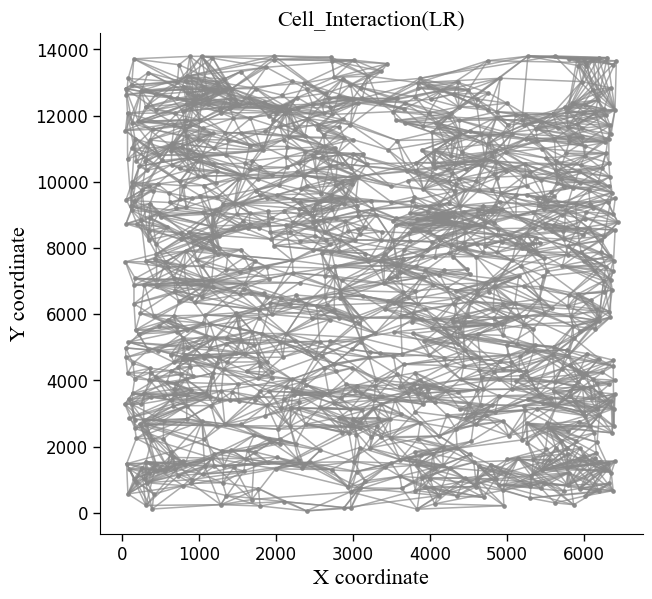

In [28]:
# 配体-受体对
ligand_receptor_pairs = [('Sst', 'Sstr2'), ('Vip', 'Ramp3'), ('Bsg', 'Cav1')]
# 调用函数构建细胞网络图
threshold = 0.01  # 设置阈值
celllevel_adj2, edges2,edge_weights,network_relationship2 = construct_celllevel_graph_top_edges(starting_df, ligand_receptor_pairs, threshold=threshold, get_edges=True)

# 使用可视化函数显示结果
sim_fig = visualize_celllevel_graph(
   starting_df, title="Cell_Interaction(LR)", edge_trace=edges2, edge_weights=1, publication=True
)


In [10]:
celllevel_edgelist2.shape

NameError: name 'celllevel_edgelist2' is not defined

In [ ]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist2 =convert_adjacencylist2edgelist(celllevel_adj2)
assert celllevel_edgelist2.shape == (2, celllevel_adj2.shape[0] * celllevel_adj2.shape[1])


In [ ]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist2 =convert_adjacencylist2edgelist(celllevel_adj2)
assert celllevel_edgelist2.shape == (2, celllevel_adj2.shape[0] * celllevel_adj2.shape[1])

def visualize_graph_from_edges(data_df, unique_edges, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    
    all_cells_x = data_df['X'].values
    all_cells_y = data_df['Y'].values

    ax.scatter(all_cells_x, all_cells_y, s=10, color='gray', alpha=0.2, label="Background Cells")

    edge_x = []
    edge_y = []
    
    # 检查unique_edges的形状，假设为[2, N]
    if unique_edges.shape[0] != 2:
        raise ValueError("unique_edges should have shape [2, N]")
    
    num_edges = unique_edges.shape[1]
    
    for i in range(num_edges):
        source = unique_edges[0, i].item()  # 转换为Python整数
        target = unique_edges[1, i].item()
        
        if source >= len(data_df) or target >= len(data_df):
            print(f"Skipping invalid edge: {source} -> {target}")
            continue
        
        x0, y0 = data_df.loc[source, "X"], data_df.loc[source, "Y"]
        x1, y1 = data_df.loc[target, "X"], data_df.loc[target, "Y"]
        
        edge_x.extend([x0, x1, None])  # 添加None分隔线段
        edge_y.extend([y0, y1, None])
    
    # 绘制边
    ax.plot(edge_x, edge_y, color='black', linewidth=0.5, alpha=0.6)
    
    ax.set_xlabel("X coordinate", fontsize=14)
    ax.set_ylabel("Y coordinate", fontsize=14)
    ax.tick_params

visualize_graph_from_edges(starting_df, celllevel_edgelist2, figsize=(10, 8))

In [123]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist2 =convert_adjacencylist2edgelist(celllevel_adj2)

In [124]:
celllevel_edgelist2

array([[   0,    0,    0, ...,    1,    1,    1],
       [   0,    0,    0, ..., 1121, 1143,  978]], dtype=int64)

In [101]:
def convert_adjacencylist2edgelist(adj_list):
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors)) : edge list representation
    '''
    
    edge_list = []  # 用于存储转换后的边列表
    
    for node, neighbors in enumerate(adj_list):  # 遍历每个节点及其邻居
        for neighbor in neighbors:  # 遍历当前节点的每个邻居
            edge_list.append([node, neighbor])  # 将节点和邻居组成一条边
            
    return np.array(edge_list).T  # 将边列表转换为 NumPy 数组并进行转置
celllevel_edgelist2 = convert_adjacencylist2edgelist(celllevel_adj2)
print(celllevel_edgelist2.shape)  # 输出 (2, 多少个边)
assert celllevel_edgelist2.shape == (2, sum(len(neighbors) for neighbors in celllevel_adj2))

(2, 3235)


In [35]:
# 配体-受体对
ligand_receptor_pairs = [('Sst', 'Sstr2'), ('Vip', 'Ramp3'), ('Bsg', 'Cav1')]
# 调用函数构建细胞网络图
threshold = 0.6  # 设置阈值
celllevel_adj2, edges2, edge_weights2,network_relationship2 = construct_celllevel_graph_top_edges(starting_df, ligand_receptor_pairs, threshold=threshold, get_edges=True)

# 使用可视化函数显示结果
#sim_fig = visualize_celllevel_graph(
#    starting_df, title="Cell_Interaction(LR)", edge_trace=edges2, edge_weights=edge_weights2, publication=True
#)


In [7]:
配体列表 (lig_list): ['Sst', 'Sst', 'Sst', 'Sst', 'Sst', 'Agrp', 'Agrp', 'Agrp', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Oxt', 'Oxt', 'Sema3C', 'Sema3C', 'Sema3C', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Prok2', 'Prok2', 'Mfge8', 'Mfge8', 'Ptgs2', 'Ptgs2', 'Ptgs2', 'Rspo2', 'Nxph2', 'Reln', 'Bsg', 'Reln', 'Bsg', 'Spp1', 'Bsg', 'Vip', 'Sema3C', 'Apoe', 'Ptgs2', 'Tac1', 'Tac2', 'Rspo2', 'Apoe', 'Spp1', 'Reln', 'Mfge8', 'Reln', 'Trf', 'Apoe', 'Mfge8', 'Apoe', 'Sema3C', 'Bsg', 'Spp1', 'Cntn6', 'Reln', 'Spp1', 'Mfge8', 'Npy', 'Tac1', 'Tac2', 'Apoe', 'Trf', 'Tac1', 'Tac2', 'Apoe', 'Tac1', 'Apoe', 'Rspo2', 'Apoe', 'Spp1', 'Bsg', 'Rspo2', 'Bsg', 'Apoe', 'Bsg', 'Spp1', 'Apoe', 'Apoe', 'Spp1', 'Reln', 'Reln', 'Spp1', 'Apoe', 'Reln', 'Apoe', 'Sst', 'Vip', 'Bsg']
受体列表 (rec_list): ['Sstr2', 'Ramp3', 'Cav1']
    
符合条件的配体-受体对: [('Sst', 'Sstr2'), ('Vip', 'Ramp3'), ('Bsg', 'Cav1')]
    
    
    

SyntaxError: illegal target for annotation (3332495282.py, line 1)

In [10]:
import numpy as np

def construct_celllevel_graph_top_edges(data_df, ligand_receptor_pairs, threshold=0.5, sigma=800, k=5, get_edges=True):
    """
    优化版本：基于配体-受体表达和空间距离构建细胞图，正确存储邻接矩阵和边权重
    
    改进点：
    1. 修复坐标变量作用域问题
    2. 添加阈值过滤逻辑
    3. 完善边去重机制
    4. 确保邻接矩阵有效性
    """
    num_cells = len(data_df)
    adjacency = np.full((num_cells, k), -1, dtype=int)  # 用-1初始化无效位置
    edge_x, edge_y = [], []
    edge_weights = []
    edge_weight_matrix = np.zeros((num_cells, num_cells))
    coords = data_df[["X", "Y"]].values

    # 计算总交互矩阵
    total_interaction_matrix = np.zeros((num_cells, num_cells))
    for ligand, receptor in ligand_receptor_pairs:
        L = data_df[ligand].values
        R = data_df[receptor].values
        
        # 向量化计算交互矩阵
        valid_L = L > 0
        valid_R = R > 0
        interaction = np.outer(L, R)
        interaction[~valid_L, :] = 0  # 无效配体清零
        interaction[:, ~valid_R] = 0  # 无效受体清零
        total_interaction_matrix += interaction

    # 应用空间衰减
    dist_matrix = np.linalg.norm(coords[:, None] - coords, axis=2)
    total_interaction_matrix *= np.exp(-(dist_matrix**2)/(2*sigma**2))

    # 构建邻接矩阵和边权重
    seen_edges = set()
    for i in range(num_cells):
        # 获取当前细胞坐标
        x0, y0 = data_df.loc[i, ["X", "Y"]]
        
        # 获取有效邻居
        strengths = total_interaction_matrix[i].copy()
        strengths[i] = -np.inf  # 排除自连接
        sorted_indices = np.argsort(strengths)[::-1][:k]  # 降序排序
        
        # 填充邻接矩阵
        valid_neighbors = []
        for idx in sorted_indices:
            if strengths[idx] >= threshold and len(valid_neighbors) < k:
                valid_neighbors.append(idx)
        
        # 填充有效邻居（不足k个用-1填充）
        adjacency[i, :len(valid_neighbors)] = valid_neighbors
        
        # 记录边信息
        for j in valid_neighbors:
            edge_tuple = tuple(sorted((i, j)))
            if edge_tuple not in seen_edges:
                seen_edges.add(edge_tuple)
                edge_weight_matrix[i, j] = total_interaction_matrix[i, j]
                edge_weight_matrix[j, i] = total_interaction_matrix[i, j]
                
                if get_edges:
                    x1, y1 = data_df.loc[j, ["X", "Y"]]
                    edge_x.extend([x0, x1, None])  # 添加None分隔线段
                    edge_y.extend([y0, y1, None])
                    edge_weights.append(total_interaction_matrix[i, j])

    # 后处理：移除无效的-1填充
    adjacency = np.where(adjacency != -1, adjacency, 0)
    
    return adjacency, (edge_x, edge_y), edge_weights, edge_weight_matrix

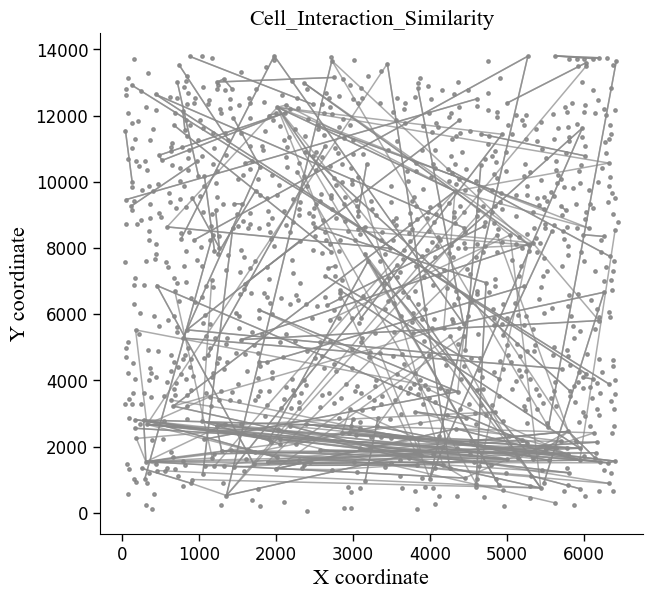

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def construct_celllevel_graph_similarity_optimized(data_df, k, threshold=0.5, get_edges=False):
    '''
    基于特征相似度和kNN方法构建细胞图，使用基因共表达作为背景信息。
    
    :param data_df: pd.DataFrame : 包含 ["Cell_ID", "X", "Y"] 和特征列的 DataFrame
    :param k: int: 用于构建空间边的最近邻个数
    :param threshold: float: 相似度的最小阈值，用于确定有效邻居 (0 < threshold <= 1)
    :param get_edges: boolean: 是否返回 edge_trace（用于可视化）
    
    :return: adjacency (2D array), edges (optional), edge_weights (optional), edge_weight_matrix (optional)
    '''
    # 第1步：数据预处理 - 选择仅包含数值型特征的列
    feature_df = data_df.drop(columns=["Cell_ID", "X", "Y", "Cell_Type"], errors='ignore')
    feature_df = feature_df.select_dtypes(include=[np.number])  # 仅选择数值型列
    
    # 第2步：数据标准化
    feature_matrix = feature_df.values
    feature_matrix = (feature_matrix - feature_matrix.mean(axis=0)) / feature_matrix.std(axis=0)  # Z-Score标准化


    
    # 第4步：计算余弦相似度
    similarity_matrix = cosine_similarity(feature_matrix)
    
    # 第5步：初始化邻接矩阵和边列表
    num_cells = len(data_df)
    adjacency = np.zeros((num_cells, k), dtype=int)  # 邻接矩阵：每个细胞最多k个邻居
    edge_x, edge_y = [], []
    edge_weights = []  # 用于存储相似度作为边的权重
    edge_weight_matrix = np.zeros((num_cells, num_cells))  # 初始化边权重矩阵
    seen_edges = set()  # 用于记录已见过的边，避免重复
    # 第6步：寻找k个最近邻
    for i in range(num_cells):
        similarities = similarity_matrix[i]
        similarities[i] = -1  # 排除自身相似度
        valid_neighbors = np.where(similarities >= threshold)[0]
        
        # 如果有效邻居少于k个，则取所有有效邻居
        if len(valid_neighbors) < k:
            neighbors = valid_neighbors
        else:
            neighbors = valid_neighbors[np.argsort(similarities[valid_neighbors])[-k:]]
                
        strengths = similarity_matrix[i].copy()  # 当前细胞的交互强度
        strengths[i] = -np.inf  # 排除自连接（对角线置为负无穷）
        sorted_indices = np.argsort(strengths)[::-1][:k]  # 对交互强度降序排序，取前k个强度最大的邻居
        #valid = sorted_indices[:k]

        # Fill adjacency list with valid neighbors
        adjacency[i, :len(sorted_indices)] = sorted_indices
        # 填充邻接矩阵
        #adjacency[i, :len(neighbors)] = neighbors
        
        # 如果需要边的坐标，添加到边列表
        if get_edges:
            x0, y0 = data_df["X"].values[i], data_df["Y"].values[i]
            for ncell in neighbors:
                x1, y1 = data_df["X"].values[ncell], data_df["Y"].values[ncell]
                edge_x.extend([x0, x1])
                edge_y.extend([y0, y1])
                edge_weights.append(similarities[ncell])  # 存储相似度作为边的权重

                # 更新边权重矩阵
                edge_weight_matrix[i, ncell] = similarities[ncell]
                edge_weight_matrix[ncell, i] = similarities[ncell]  # 对称

    edges = [edge_x, edge_y] if get_edges else None
    return adjacency, edges, edge_weights, edge_weight_matrix

# 调用函数并获取结果
celllevel_adj3, edges3, edge_weights3, network_relationship3 = construct_celllevel_graph_similarity_optimized(starting_df, 2, 0.3, get_edges=True)

# 使用可视化函数显示结果
sim_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction_Similarity", edge_trace=edges3, edge_weights=edge_weights3, publication=True
)




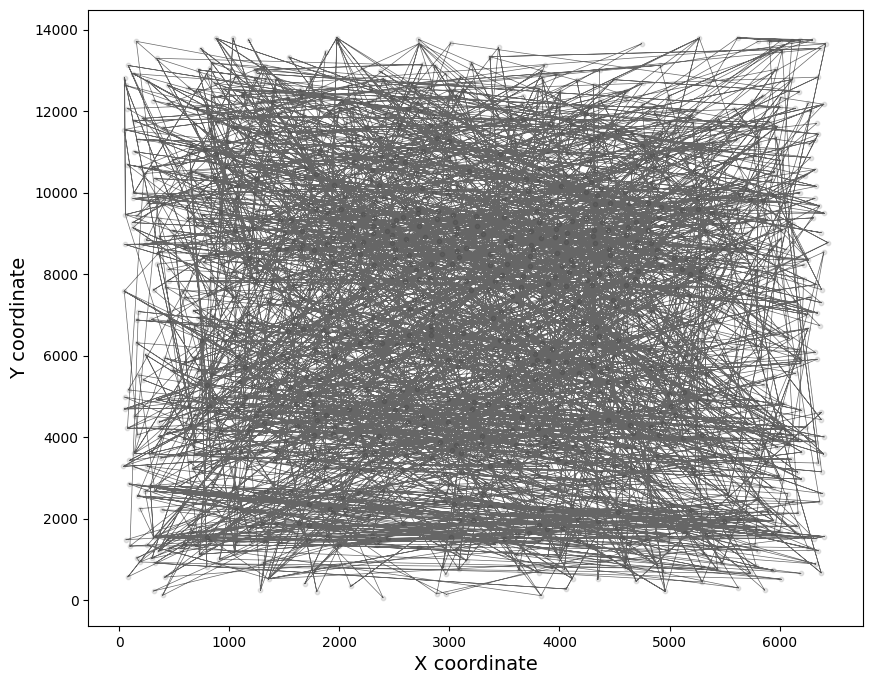

In [12]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist3 =convert_adjacencylist2edgelist(celllevel_adj3)
assert celllevel_edgelist3.shape == (2, celllevel_adj3.shape[0] * celllevel_adj3.shape[1])

def visualize_graph_from_edges(data_df, unique_edges, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    
    all_cells_x = data_df['X'].values
    all_cells_y = data_df['Y'].values

    ax.scatter(all_cells_x, all_cells_y, s=10, color='gray', alpha=0.2, label="Background Cells")

    edge_x = []
    edge_y = []
    
    # 检查unique_edges的形状，假设为[2, N]
    if unique_edges.shape[0] != 2:
        raise ValueError("unique_edges should have shape [2, N]")
    
    num_edges = unique_edges.shape[1]
    
    for i in range(num_edges):
        source = unique_edges[0, i].item()  # 转换为Python整数
        target = unique_edges[1, i].item()
        
        if source >= len(data_df) or target >= len(data_df):
            print(f"Skipping invalid edge: {source} -> {target}")
            continue
        
        x0, y0 = data_df.loc[source, "X"], data_df.loc[source, "Y"]
        x1, y1 = data_df.loc[target, "X"], data_df.loc[target, "Y"]
        
        edge_x.extend([x0, x1, None])  # 添加None分隔线段
        edge_y.extend([y0, y1, None])
    
    # 绘制边
    ax.plot(edge_x, edge_y, color='black', linewidth=0.5, alpha=0.6)
    
    ax.set_xlabel("X coordinate", fontsize=14)
    ax.set_ylabel("Y coordinate", fontsize=14)
    ax.tick_params

visualize_graph_from_edges(starting_df, celllevel_edgelist3, figsize=(10, 8))

In [224]:
def normalize_network_relationship(network_relationship):
    # 获取最小值和最大值
    min_val = np.min(network_relationship)
    max_val = np.max(network_relationship)
    
    # 执行最大-最小归一化
    normalized_network_relationship = (network_relationship - min_val) / (max_val - min_val)
    
    return normalized_network_relationship

# 对 network_relationship 进行归一化
network_relationship3 = normalize_network_relationship(network_relationship3)
network_relationship3*0.5
network_relationship2 = normalize_network_relationship(network_relationship2)
network_relationship1 = normalize_network_relationship(network_relationship1)

In [225]:
network_relationship1.shape

(1207, 1207)

In [226]:
network_relationship2.shape

(1207, 1207)

In [227]:
network_relationship3

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

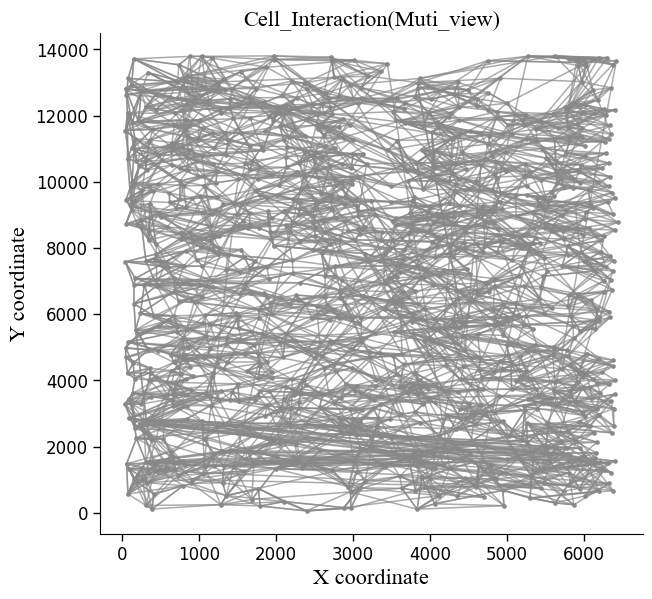

In [30]:
def construct_celllevel_graph_combined(data_df, network_relationships, k, threshold=0.7, get_edges=True):
    '''
    将多个网络关系矩阵合并为一个邻接图，考虑来自多个来源的交互。

    :param data_df: pd.DataFrame : 代表空间数据，包含 ["Cell_ID", "X", "Y"]
    :param network_relationships: list : 网络关系矩阵列表（如空间、配体-受体）
    :param k: int : 每个细胞的邻居数量
    :param threshold: float : 合并邻接矩阵的阈值（调整为所需的相似度水平）
    :param get_edges: boolean : 是否返回边的坐标（用于可视化）

    :return: 合并后的邻接矩阵、边列表、边权重、合并后的边权重矩阵
    '''
    num_cells = len(data_df)
    combined_adjacency = np.zeros((num_cells, k), dtype=int)  # 初始化合并后的邻接矩阵
    combined_edge_x, combined_edge_y = [], []
    combined_edge_weights = []  # 存储每条边的权重
    combined_edge_weight_matrix = np.zeros((num_cells, num_cells))  # 合并后的边权重矩阵

    # 对于每个细胞，考虑所有网络关系中的交互
    for i in range(num_cells):
        cell_neighbors = []

        # 步骤1: 计算所有关系矩阵中的综合相似度（对于每个细胞，结合所有关系矩阵）
        aggregated_scores = np.sum([relationship[i] for relationship in network_relationships], axis=0)  # 求和合并所有关系的得分
        # 步骤2: 查找综合得分大于阈值的邻居
        valid_neighbors = np.where(aggregated_scores >= threshold)[0]  # 根据综合得分筛选邻居
        cell_neighbors.extend(valid_neighbors[:k])  # 限制邻居数不超过k个
        
        # 步骤3: 更新合并后的邻接矩阵

        combined_adjacency[i, :min(len(valid_neighbors), k)] = valid_neighbors[:k]  # 确保最多取k个邻居
        

        if get_edges:
            x0, y0 = data_df.loc[i, ["X", "Y"]]
            for ncell in valid_neighbors[:k]:  # 只取前k个邻居
                x1, y1 = data_df.loc[ncell, ["X", "Y"]]
                combined_edge_x.extend([x0, x1])
                combined_edge_y.extend([y0, y1])
                
                # 合并边权重
                combined_strength = sum([relationship[i, ncell] for relationship in network_relationships])
                combined_edge_weights.append(combined_strength)

                # 更新合并后的边权重矩阵
                combined_edge_weight_matrix[i, ncell] = combined_strength
                combined_edge_weight_matrix[ncell, i] = combined_strength  # 对称矩阵

    return combined_adjacency, [combined_edge_x, combined_edge_y] if get_edges else None, combined_edge_weights, combined_edge_weight_matrix
celllevel_adj4, edges4, combined_edge_weights, combined_edge_weight_matrix = construct_celllevel_graph_combined(
    starting_df, [network_relationship1, network_relationship2,network_relationship3], k=5, threshold=0.1, get_edges=True
)
# 显示结果（可视化）
combined_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(Muti_view)", edge_trace=edges4, edge_weights=combined_edge_weights, publication=True
)





In [31]:
celllevel_adj4.shape

(1207, 5)

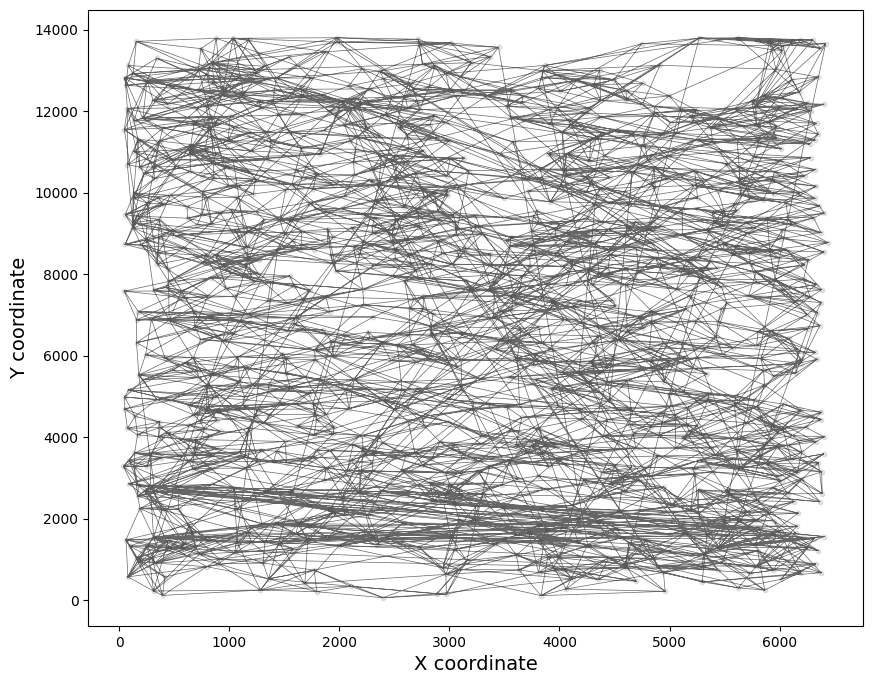

In [39]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist4 =convert_adjacencylist2edgelist(celllevel_adj4)
assert celllevel_edgelist4.shape == (2, celllevel_adj4.shape[0] * celllevel_adj4.shape[1])

def visualize_graph_from_edges(data_df, unique_edges, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    
    all_cells_x = data_df['X'].values
    all_cells_y = data_df['Y'].values

    ax.scatter(all_cells_x, all_cells_y, s=10, color='gray', alpha=0.2, label="Background Cells")

    edge_x = []
    edge_y = []
    
    # 检查unique_edges的形状，假设为[2, N]
    if unique_edges.shape[0] != 2:
        raise ValueError("unique_edges should have shape [2, N]")
    
    num_edges = unique_edges.shape[1]
    
    for i in range(num_edges):
        source = unique_edges[0, i].item()  # 转换为Python整数
        target = unique_edges[1, i].item()
        
        if source >= len(data_df) or target >= len(data_df):
            print(f"Skipping invalid edge: {source} -> {target}")
            continue
        
        x0, y0 = data_df.loc[source, "X"], data_df.loc[source, "Y"]
        x1, y1 = data_df.loc[target, "X"], data_df.loc[target, "Y"]
        
        edge_x.extend([x0, x1, None])  # 添加None分隔线段
        edge_y.extend([y0, y1, None])
    
    # 绘制边
    ax.plot(edge_x, edge_y, color='black', linewidth=0.5, alpha=0.6)
    
    ax.set_xlabel("X coordinate", fontsize=14)
    ax.set_ylabel("Y coordinate", fontsize=14)
    ax.tick_params

visualize_graph_from_edges(starting_df, unique_edges, figsize=(10, 8))

In [82]:
celllevel_adj4

array([[   8,    0,    0,    0,    0],
       [  41,    0,    0,    0,    0],
       [  47,   77,   95,  172,  199],
       ...,
       [1085, 1127, 1178, 1186,    0],
       [ 978, 1121, 1143, 1168, 1192],
       [1087, 1109, 1127, 1156, 1178]])

In [76]:
celllevel_adj1.shape

(1207, 5)

In [77]:
celllevel_adj2.shape

(1207, 5)

In [78]:
celllevel_adj2

array([[  -1,   -1,   -1,   -1,   -1],
       [  -1,   -1,   -1,   -1,   -1],
       [  77,   95,  199,  172,   47],
       ...,
       [  -1,   -1,   -1,   -1,   -1],
       [1121, 1143,  978,   -1,   -1],
       [  -1,   -1,   -1,   -1,   -1]])

In [192]:
celllevel_adj3.shape

(1207, 5)

In [33]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist1 =convert_adjacencylist2edgelist(celllevel_adj1)
assert celllevel_edgelist1.shape == (2, celllevel_adj1.shape[0] * celllevel_adj1.shape[1])
##############
celllevel_edgelist2 =convert_adjacencylist2edgelist(celllevel_adj2)
assert celllevel_edgelist2.shape == (2, celllevel_adj2.shape[0] * celllevel_adj2.shape[1])
##############
celllevel_edgelist3 =convert_adjacencylist2edgelist(celllevel_adj3)
assert celllevel_edgelist3.shape == (2, celllevel_adj3.shape[0] * celllevel_adj3.shape[1])
###########
celllevel_edgelist4 = convert_adjacencylist2edgelist(celllevel_adj4)
assert celllevel_edgelist4.shape == (2, celllevel_adj4.shape[0] * celllevel_adj4.shape[1])

def convert_adjacencylist2adjacencymatrix(adj_list):
    
    num_vertices = len(adj_list)
    adj_matrix = np.zeros(shape=(num_vertices,num_vertices))
     
    for i in range(num_vertices):
        for j in adj_list[i]:
            adj_matrix[i][j] = 1
            adj_matrix[j][i] = 1
     
    return adj_matrix
import os

preprocess_output_path = ".new5k5"

if not os.path.exists(preprocess_output_path):
    os.makedirs(preprocess_output_path)
    print(f"路径 {preprocess_output_path} 创建成功！")
else:
    print(f"路径 {preprocess_output_path} 已经存在。")
# 保存邻接矩阵和边列表（从1到4）
for i in range(1, 5):  # 从1到4
    # 假设你有celllevel_adj和celllevel_edgelist数据
    adj_matrix = convert_adjacencylist2adjacencymatrix(globals()[f'celllevel_adj{i}'])  # 动态获取celllevel_adj1, celllevel_adj2, ...
    np.save(os.path.join(preprocess_output_path, f"celllevel_adjacencymatrix{i}.npy"), adj_matrix)
    print(f"Adjacency matrix saved to {os.path.join(preprocess_output_path, f'celllevel_adjacencymatrix{i}.npy')}")
    
    np.save(os.path.join(preprocess_output_path, f"celllevel_edgelist{i}.npy"), globals()[f'celllevel_edgelist{i}'])  # 动态获取celllevel_edgelist1, celllevel_edgelist2, ...
    print(f"Edge list saved to {os.path.join(preprocess_output_path, f'celllevel_edgelist{i}.npy')}")
    
    

路径 .new5k5 已经存在。
Adjacency matrix saved to .new5k5\celllevel_adjacencymatrix1.npy
Edge list saved to .new5k5\celllevel_edgelist1.npy
Adjacency matrix saved to .new5k5\celllevel_adjacencymatrix2.npy
Edge list saved to .new5k5\celllevel_edgelist2.npy
Adjacency matrix saved to .new5k5\celllevel_adjacencymatrix3.npy
Edge list saved to .new5k5\celllevel_edgelist3.npy
Adjacency matrix saved to .new5k5\celllevel_adjacencymatrix4.npy
Edge list saved to .new5k5\celllevel_edgelist4.npy


In [34]:
celllevel_edgelist4.shape

(2, 6035)

In [22]:
import numpy as np

def remove_duplicate_edges(edges):
    """
    去除重复的边，保证无向图中的边 (i, j) 和 (j, i) 视为相同。
    :param edges: np.ndarray : 形状为 [2, N] 的边列表，第一行是源节点，第二行是目标节点的索引
    :return: np.ndarray : 去重后的边列表
    """
    # 创建一个空集合来存储唯一的边
    unique_edges = set()

    # 遍历所有的边
    for i in range(edges.shape[1]):
        source, target = edges[:, i]
        
        # 无向图中，(source, target) 和 (target, source) 应视为相同边
        if source > target:
            source, target = target, source  # 保证 source < target，排序
        
        # 将有序的边元组加入集合，集合会自动去重
        unique_edges.add((source, target))
    
    # 将集合转换回 numpy 数组，并转置为 [2, N]
    unique_edges = np.array(list(unique_edges)).T
    
    return unique_edges

# 使用示例
unique_edges = remove_duplicate_edges(celllevel_edgelist4)
print(f"去重后的边列表形状: {unique_edges.shape}")


去重后的边列表形状: (2, 5454)


In [23]:
unique_edges

array([[524, 394, 347, ..., 320, 484,  14],
       [563, 453, 378, ..., 383, 491,  47]])

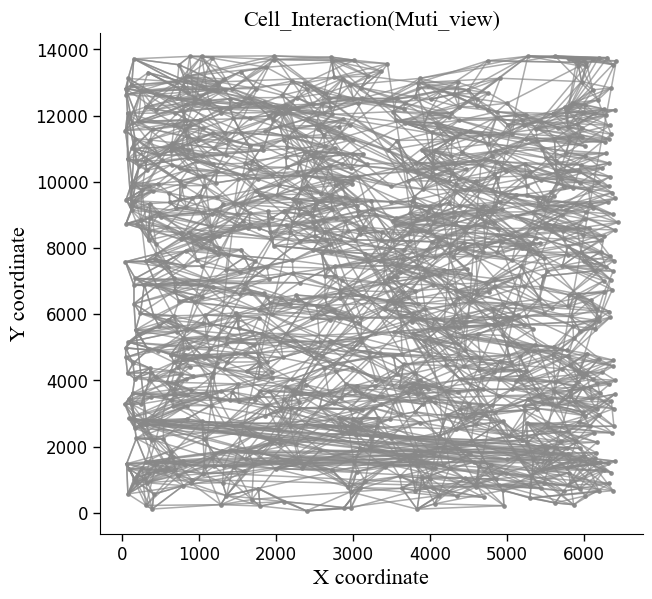

In [22]:
def construct_celllevel_graph_combined(data_df, network_relationships, k, threshold=0.7, get_edges=True):
    '''
    将多个网络关系矩阵合并为一个邻接图，考虑来自多个来源的交互。

    :param data_df: pd.DataFrame : 代表空间数据，包含 ["Cell_ID", "X", "Y"]
    :param network_relationships: list : 网络关系矩阵列表（如空间、配体-受体）
    :param k: int : 每个细胞的邻居数量
    :param threshold: float : 合并邻接矩阵的阈值（调整为所需的相似度水平）
    :param get_edges: boolean : 是否返回边的坐标（用于可视化）

    :return: 合并后的邻接矩阵、边列表、边权重、合并后的边权重矩阵
    '''
    num_cells = len(data_df)
    combined_adjacency = np.zeros((num_cells, k), dtype=int)  # 初始化合并后的邻接矩阵
    combined_edge_x, combined_edge_y = [], []
    combined_edge_weights = []  # 存储每条边的权重
    combined_edge_weight_matrix = np.zeros((num_cells, num_cells))  # 合并后的边权重矩阵

    # 对于每个细胞，考虑所有网络关系中的交互
    for i in range(num_cells):
        cell_neighbors = []

        aggregated_scores = np.sum([relationship[i] for relationship in network_relationships], axis=0)
        valid_neighbors = np.where(aggregated_scores >= threshold)[0]  # 根据综合得分筛选邻居
        cell_neighbors.extend(valid_neighbors[:k])  # 限制邻居数不超过k个
        
        # 步骤3: 更新合并后的邻接矩阵
        unique_neighbors = list(set(cell_neighbors))  # 去重后的邻居列表
        combined_adjacency[i, :min(len(unique_neighbors), k)] = unique_neighbors[:k]  # 确保最多取k个邻居
        
        # 步骤4: 收集边的细节用于可视化（可选）
        if get_edges:
            x0, y0 = data_df.loc[i, ["X", "Y"]]
            for ncell in unique_neighbors[:k]:  # 只取前k个邻居
                x1, y1 = data_df.loc[ncell, ["X", "Y"]]
                combined_edge_x.extend([x0, x1])
                combined_edge_y.extend([y0, y1])
                
                # 合并边权重
                combined_strength = sum([relationship[i, ncell] for relationship in network_relationships])
                combined_edge_weights.append(combined_strength)

                # 更新合并后的边权重矩阵
                combined_edge_weight_matrix[i, ncell] = combined_strength
                combined_edge_weight_matrix[ncell, i] = combined_strength  # 对称矩阵

    return combined_adjacency, [combined_edge_x, combined_edge_y] if get_edges else None, combined_edge_weights, combined_edge_weight_matrix
celllevel_adj4, edges4, combined_edge_weights, combined_edge_weight_matrix = construct_celllevel_graph_combined(
    starting_df, [network_relationship1, network_relationship2, network_relationship3], k=5, threshold=0.01, get_edges=True
)
# 显示结果（可视化）
combined_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(Muti_view)", edge_trace=edges4, edge_weights=combined_edge_weights, publication=True
)

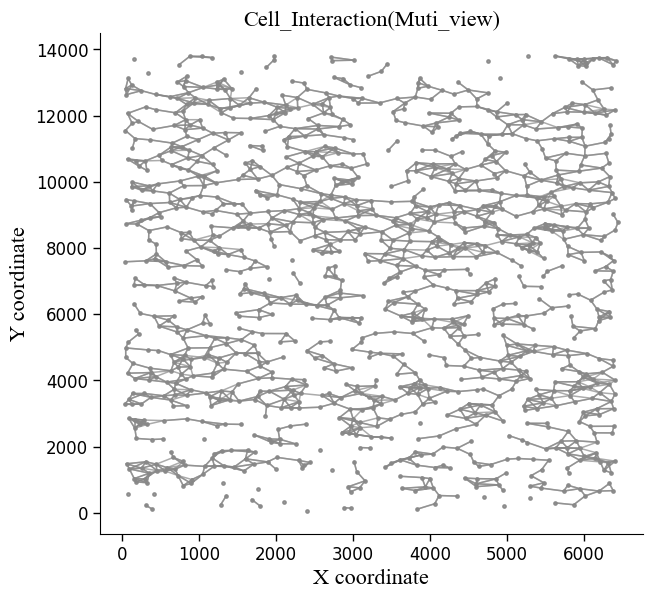

In [21]:
def construct_celllevel_graph_combined(data_df, network_relationships, k, threshold=0.7, get_edges=True):
    '''
    将多个网络关系矩阵合并为一个邻接图，考虑来自多个来源的交互。

    :param data_df: pd.DataFrame : 代表空间数据，包含 ["Cell_ID", "X", "Y"]
    :param network_relationships: list : 网络关系矩阵列表（如空间、配体-受体）
    :param k: int : 每个细胞的邻居数量
    :param threshold: float : 合并邻接矩阵的阈值（调整为所需的相似度水平）
    :param get_edges: boolean : 是否返回边的坐标（用于可视化）

    :return: 合并后的邻接矩阵、边列表、边权重、合并后的边权重矩阵
    '''
    num_cells = len(data_df)
    combined_adjacency = np.zeros((num_cells, k), dtype=int)  # 初始化合并后的邻接矩阵
    combined_edge_x, combined_edge_y = [], []
    combined_edge_weights = []  # 存储每条边的权重
    combined_edge_weight_matrix = np.zeros((num_cells, num_cells))  # 合并后的边权重矩阵

    # 对于每个细胞，考虑所有网络关系中的交互
    for i in range(num_cells):
        cell_neighbors = []

        aggregated_scores = np.sum([relationship[i] for relationship in network_relationships], axis=0)
        valid_neighbors = np.where(aggregated_scores >= threshold)[0]  # 根据综合得分筛选邻居
        cell_neighbors.extend(valid_neighbors[:k])  # 限制邻居数不超过k个
        
        # 步骤3: 更新合并后的邻接矩阵
        unique_neighbors = list(set(cell_neighbors))  # 去重后的邻居列表
        combined_adjacency[i, :min(len(unique_neighbors), k)] = unique_neighbors[:k]  # 确保最多取k个邻居
        
        # 步骤4: 收集边的细节用于可视化（可选）
        if get_edges:
            x0, y0 = data_df.loc[i, ["X", "Y"]]
            for ncell in unique_neighbors[:k]:  # 只取前k个邻居
                x1, y1 = data_df.loc[ncell, ["X", "Y"]]
                combined_edge_x.extend([x0, x1])
                combined_edge_y.extend([y0, y1])
                
                # 合并边权重
                combined_strength = sum([relationship[i, ncell] for relationship in network_relationships])
                combined_edge_weights.append(combined_strength)

                # 更新合并后的边权重矩阵
                combined_edge_weight_matrix[i, ncell] = combined_strength
                combined_edge_weight_matrix[ncell, i] = combined_strength  # 对称矩阵

    return combined_adjacency, [combined_edge_x, combined_edge_y] if get_edges else None, combined_edge_weights, combined_edge_weight_matrix
celllevel_adj4, edges4, combined_edge_weights, combined_edge_weight_matrix = construct_celllevel_graph_combined(
    starting_df, [network_relationship1], k=5, threshold=0.01, get_edges=True
)
# 显示结果（可视化）
combined_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(Muti_view)", edge_trace=edges4, edge_weights=combined_edge_weights, publication=True
)

In [78]:
celllevel_adj4

array([[   8,   67,    5,    0,    0],
       [  41,   51,    0,    0,    0],
       [  40,   26,    0,    0,    0],
       ...,
       [1186, 1178,    0,    0,    0],
       [1168, 1146, 1192,    0,    0],
       [1196, 1199,    0,    0,    0]])

In [15]:
celllevel_edgelist4 = convert_adjacencylist2edgelist(celllevel_adj4)
assert celllevel_edgelist4.shape == (2, celllevel_adj4.shape[0] * celllevel_adj4.shape[1])

In [16]:
celllevel_adj4.shape

(1207, 5)

In [17]:
celllevel_edgelist4.shape

(2, 6035)

In [44]:
import torch

celllevel_edgelist4 = torch.tensor(celllevel_edgelist4)  # 转换为 Tensor 类型

# 然后再进行排序操作
sorted_edges = torch.sort(celllevel_edgelist4, dim=0)[0]

# 使用集合去重
unique_edges_set = set(tuple(edge) for edge in sorted_edges.t().tolist())

# 将集合中的边重新转换为张量
unique_edges = torch.tensor(list(unique_edges_set)).T

# 查看去重后的边索引
print(f"Original edge count: {celllevel_edgelist4.shape[1]}")
print(f"Unique edge count: {unique_edges.shape[1]}")
#np.save('adj_matrix1.npy', adj_matrix)
np.save('adj_list4.npy', unique_edges)

Original edge count: 6035
Unique edge count: 5150


In [46]:
adj_matrix = convert_adjacencylist2adjacencymatrix(unique_edges)

IndexError: index 347 is out of bounds for axis 0 with size 2

In [ ]:
unique_edges.shape

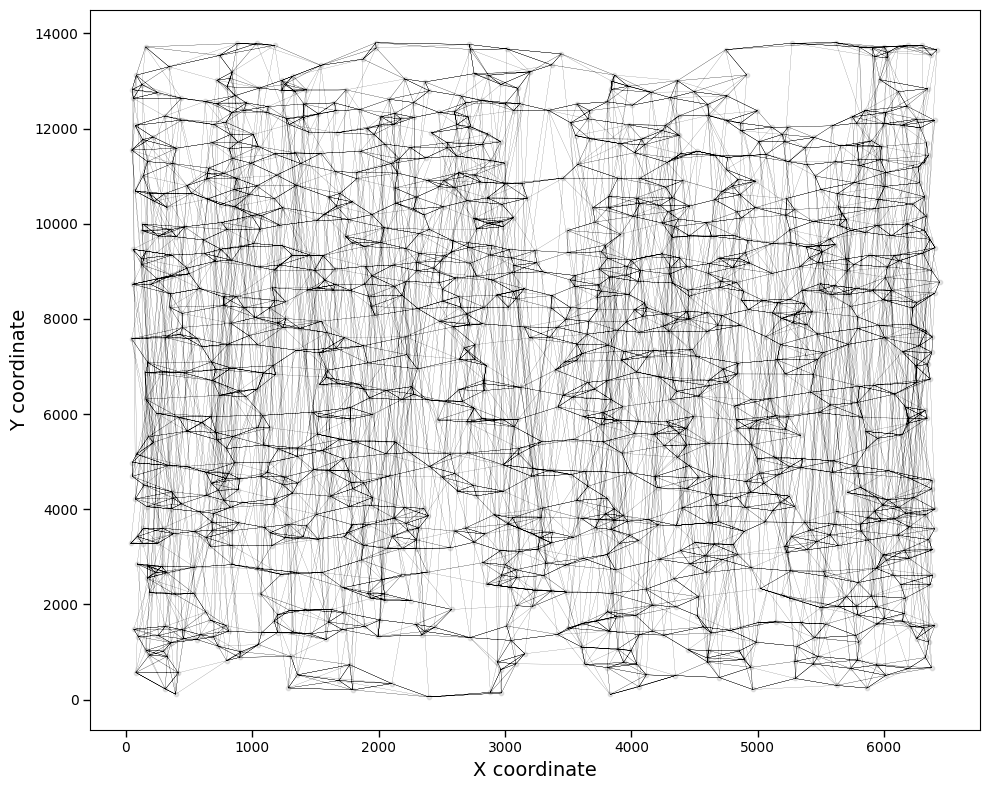

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_graph_from_edges(data_df, unique_edges, figsize=(10, 8)):
    """
    可视化根据去重后的边构建的图
    :param data_df: pd.DataFrame : 包含 ["Cell_ID", "X", "Y"] 的数据
    :param unique_edges: Tensor : 形状为 [2, N] 的张量，包含边的源节点和目标节点的索引
    :param figsize: Tuple : 图形的大小
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # 获取节点的坐标
    all_cells_x = data_df['X'].values
    all_cells_y = data_df['Y'].values

    # 绘制所有细胞作为背景点
    ax.scatter(all_cells_x, all_cells_y, s=10, color='gray', alpha=0.2, label="Background Cells")

    # 恢复边的坐标
    edge_x, edge_y = [], []
    for i in range(unique_edges.shape[1]):
        source, target = unique_edges[:, i]
        
        # 确保索引是整数类型
        source = int(source)
        target = int(target)
        
        # 确保索引在有效范围内
        if source < len(data_df) and target < len(data_df):
            x0, y0 = data_df.loc[source, ["X", "Y"]]
            x1, y1 = data_df.loc[target, ["X", "Y"]]
        
            # 构建边的坐标（用于可视化）
            edge_x.append(x0)
            edge_x.append(x1)

            edge_y.append(y0)
            edge_y.append(y1)

        else:
            print(f"Skipping invalid edge: {source} -> {target}")
        assert source < len(starting_df), f"Invalid source index: {source}"
        assert target < len(starting_df), f"Invalid target index: {target}"
    
    # 绘制边
    ax.plot(edge_x, edge_y, color='black', lw=0.1)

    # 设置坐标轴标签
    ax.set_xlabel("X coordinate", fontsize=14)
    ax.set_ylabel("Y coordinate", fontsize=14)
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # 显示图表
    plt.tight_layout()
    plt.show()


visualize_graph_from_edges(starting_df, celllevel_edgelist1, figsize=(10, 8))


In [47]:
def construct_celllevel_graph_combined(data_df, network_relationships, k, threshold=0.7, get_edges=True):
    '''
    将多个网络关系矩阵合并为一个邻接图，考虑来自多个来源的交互。

    :param data_df: pd.DataFrame : 代表空间数据，包含 ["Cell_ID", "X", "Y"]
    :param network_relationships: list : 网络关系矩阵列表（如空间、配体-受体）
    :param k: int : 每个细胞的邻居数量
    :param threshold: float : 合并邻接矩阵的阈值（调整为所需的相似度水平）
    :param get_edges: boolean : 是否返回边的坐标（用于可视化）

    :return: 合并后的邻接矩阵、边列表、边权重、合并后的边权重矩阵
    '''
    num_cells = len(data_df)
    combined_adjacency = np.zeros((num_cells, k), dtype=int)  # 初始化合并后的邻接矩阵
    combined_edge_x, combined_edge_y = [], []
    combined_edge_weights = []  # 存储每条边的权重
    combined_edge_weight_matrix = np.zeros((num_cells, num_cells))  # 合并后的边权重矩阵
    added_edges = set()  # 用于存储已添加的边，避免重复

    # 对于每个细胞，考虑所有网络关系中的交互
    for i in range(num_cells):
        cell_neighbors = []

        # 步骤1: 计算所有关系矩阵中的综合相似度（对于每个细胞，结合所有关系矩阵）
        aggregated_scores = np.sum([relationship[i] for relationship in network_relationships], axis=0)  # 求和合并所有关系的得分
        # 步骤2: 查找综合得分大于阈值的邻居
        valid_neighbors = np.where(aggregated_scores >= threshold)[0]  # 根据综合得分筛选邻居
        cell_neighbors.extend(valid_neighbors[:k])  # 限制邻居数不超过k个
        
        # 步骤3: 更新合并后的邻接矩阵
        unique_neighbors = list(set(cell_neighbors))  # 去重后的邻居列表
        combined_adjacency[i, :min(len(unique_neighbors), k)] = unique_neighbors[:k]  # 确保最多取k个邻居
        
        # 步骤4: 收集边的细节用于可视化（可选）
        if get_edges:
            x0, y0 = data_df.loc[i, ["X", "Y"]]
            for ncell in unique_neighbors[:k]:  # 只取前k个邻居
                x1, y1 = data_df.loc[ncell, ["X", "Y"]]
                
                # 确保边唯一，避免重复
                edge_tuple = tuple(sorted([i, ncell]))  # 用排序的方式确保无向边唯一
                if edge_tuple not in added_edges:
                    added_edges.add(edge_tuple)  # 标记这条边已添加
                    combined_edge_x.extend([x0, x1])
                    combined_edge_y.extend([y0, y1])
                    
                    # 合并边权重
                    combined_strength = sum([relationship[i, ncell] for relationship in network_relationships])
                    combined_edge_weights.append(combined_strength)

                    # 更新合并后的边权重矩阵
                    combined_edge_weight_matrix[i, ncell] = combined_strength
                    combined_edge_weight_matrix[ncell, i] = combined_strength  # 对称矩阵

    return combined_adjacency, [combined_edge_x, combined_edge_y] if get_edges else None, combined_edge_weights, combined_edge_weight_matrix


In [18]:
def construct_celllevel_graph_combined(data_df, network_relationships, k, threshold=0.7, get_edges=True):
    '''
    将多个网络关系矩阵合并为一个邻接图，考虑来自多个来源的交互。

    :param data_df: pd.DataFrame : 代表空间数据，包含 ["Cell_ID", "X", "Y"]
    :param network_relationships: list : 网络关系矩阵列表（如空间、配体-受体）
    :param k: int : 每个细胞的邻居数量
    :param threshold: float : 合并邻接矩阵的阈值（调整为所需的相似度水平）
    :param get_edges: boolean : 是否返回边的坐标（用于可视化）

    :return: 合并后的邻接矩阵、边列表、边权重、合并后的边权重矩阵
    '''
    num_cells = len(data_df)
    combined_adjacency = np.zeros((num_cells, k), dtype=int)  # 初始化合并后的邻接矩阵
    combined_edge_x, combined_edge_y = [], []
    combined_edge_weights = []  # 存储每条边的权重
    combined_edge_weight_matrix = np.zeros((num_cells, num_cells))  # 合并后的边权重矩阵
    added_edges = set()  # 用于存储已添加的边，避免重复

    # 对于每个细胞，考虑所有网络关系中的交互
    for i in range(num_cells):
        cell_neighbors = []
        
        # 步骤1: 计算所有关系矩阵中的综合相似度（对于每个细胞，结合所有关系矩阵）
        aggregated_scores = np.sum([relationship[i] for relationship in network_relationships], axis=0)  # 求和合并所有关系的得分
        # 步骤2: 查找综合得分大于阈值的邻居
        valid_neighbors = np.where(aggregated_scores >= threshold)[0]  # 根据综合得分筛选邻居
        unique_neighbors = list(set(valid_neighbors))  # 去重后的邻居列表

        # 步骤3: 确保每个细胞都有 k 个邻居
        for neighbor in unique_neighbors:
            if len(cell_neighbors) < k:  # 如果当前邻居数量小于 k，添加邻居
                edge_tuple = tuple(sorted([i, neighbor]))  # 确保边唯一
                if edge_tuple not in added_edges:  # 如果该边未添加过
                    added_edges.add(edge_tuple)
                    cell_neighbors.append(neighbor)
            
        # 如果去重后的邻居数小于 k，继续寻找更多邻居直到满足 k 个
        if len(cell_neighbors) < k:
            for neighbor in valid_neighbors:
                edge_tuple = tuple(sorted([i, neighbor]))
                if edge_tuple not in added_edges:
                    added_edges.add(edge_tuple)
                    cell_neighbors.append(neighbor)
                if len(cell_neighbors) == k:
                    break

        # 步骤4: 更新合并后的邻接矩阵
        combined_adjacency[i, :min(len(cell_neighbors), k)] = cell_neighbors[:k]

        # 步骤5: 收集边的细节用于可视化（可选）
        if get_edges:
            x0, y0 = data_df.loc[i, ["X", "Y"]]
            for ncell in cell_neighbors[:k]:  # 只取前k个邻居
                x1, y1 = data_df.loc[ncell, ["X", "Y"]]
                combined_edge_x.extend([x0, x1])
                combined_edge_y.extend([y0, y1])

                # 合并边权重
                combined_strength = sum([relationship[i, ncell] for relationship in network_relationships])
                combined_edge_weights.append(combined_strength)

                # 更新合并后的边权重矩阵
                combined_edge_weight_matrix[i, ncell] = combined_strength
                combined_edge_weight_matrix[ncell, i] = combined_strength  # 对称矩阵

    return combined_adjacency, [combined_edge_x, combined_edge_y] if get_edges else None, combined_edge_weights, combined_edge_weight_matrix


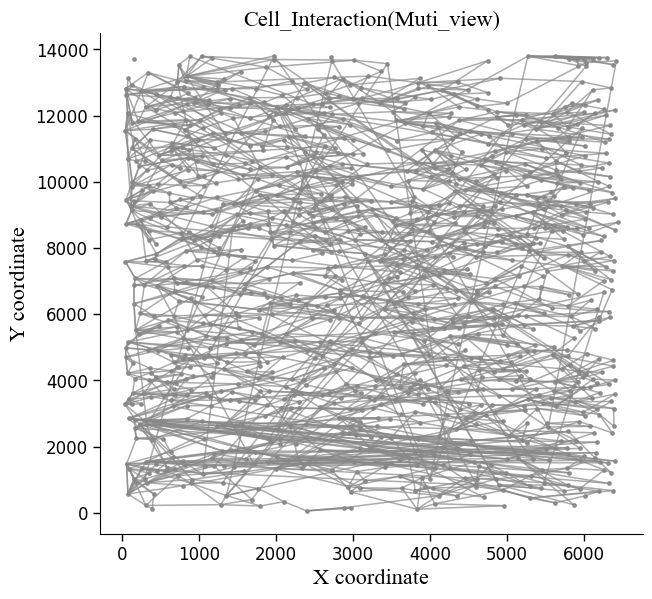

In [24]:
celllevel_adj4, edges4, combined_edge_weights, combined_edge_weight_matrix = construct_celllevel_graph_combined(
    starting_df, [network_relationship1, network_relationship2, network_relationship3], k=2, threshold=0.1, get_edges=True
)
# 显示结果（可视化）
combined_fig = visualize_celllevel_graph(
    starting_df, title="Cell_Interaction(Muti_view)", edge_trace=edges4, edge_weights=combined_edge_weights, publication=True
)



In [25]:
celllevel_adj4.shape

(1207, 2)

In [ ]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            

In [41]:

def convert_adjacencylist2adjacencymatrix(adj_list):
    
    num_vertices = len(adj_list)
    adj_matrix = np.zeros(shape=(num_vertices,num_vertices))
     
    for i in range(num_vertices):
        for j in adj_list[i]:
            adj_matrix[i][j] = 1
            adj_matrix[j][i] = 1
     
    return adj_matrix

import os

preprocess_output_path = ".new"

if not os.path.exists(preprocess_output_path):
    os.makedirs(preprocess_output_path)
    print(f"路径 {preprocess_output_path} 创建成功！")
else:
    print(f"路径 {preprocess_output_path} 已经存在。")
# 保存邻接矩阵和边列表（从1到4）
for i in range(1, 5):  # 从1到4
    # 假设你有celllevel_adj和celllevel_edgelist数据
    adj_matrix = convert_adjacencylist2adjacencymatrix(globals()[f'celllevel_adj{i}'])  # 动态获取celllevel_adj1, celllevel_adj2, ...
    np.save(os.path.join(preprocess_output_path, f"celllevel_adjacencymatrix{i}.npy"), adj_matrix)
    print(f"Adjacency matrix saved to {os.path.join(preprocess_output_path, f'celllevel_adjacencymatrix{i}.npy')}")
    
    np.save(os.path.join(preprocess_output_path, f"celllevel_edgelist{i}.npy"), globals()[f'celllevel_edgelist{i}'])  # 动态获取celllevel_edgelist1, celllevel_edgelist2, ...
    print(f"Edge list saved to {os.path.join(preprocess_output_path, f'celllevel_edgelist{i}.npy')}")
    

路径 .new 已经存在。
Adjacency matrix saved to .new\celllevel_adjacencymatrix1.npy
Edge list saved to .new\celllevel_edgelist1.npy
Adjacency matrix saved to .new\celllevel_adjacencymatrix2.npy
Edge list saved to .new\celllevel_edgelist2.npy
Adjacency matrix saved to .new\celllevel_adjacencymatrix3.npy
Edge list saved to .new\celllevel_edgelist3.npy
Adjacency matrix saved to .new\celllevel_adjacencymatrix4.npy
Edge list saved to .new\celllevel_edgelist4.npy


In [47]:
adj_matrix = convert_adjacencylist2adjacencymatrix(celllevel_adj4)

In [43]:
unique_edges.shape

torch.Size([2, 5184])

In [48]:
np.save('adj_matrix1.npy', adj_matrix)
np.save('adj_list4.npy', unique_edges)

In [28]:
adj_matrix.shape

(1207, 1207)

In [54]:
unique_edges.shape

(2, 3534)

In [49]:
preprocess_output_path = ".new"

adj_matrix = convert_adjacencylist2adjacencymatrix(globals()[f'unique_edges'])  # 动态获取celllevel_adj1, celllevel_adj2, ...
np.save(os.path.join(preprocess_output_path, f"unique_edges.npy"), adj_matrix)
print(f"Adjacency matrix saved to {os.path.join(preprocess_output_path, f'celllevel_adjacencymatrix{i}.npy')}")
    
np.save(os.path.join(preprocess_output_path, f"celllevel_edgelist{i}.npy"), globals()[f'celllevel_edgelist{i}'])  # 动态获取celllevel_edgelist1, celllevel_edgelist2, ...
print(f"Edge list saved to {os.path.join(preprocess_output_path, f'celllevel_edgelist{i}.npy')}")
    

IndexError: index 246 is out of bounds for axis 0 with size 2

In [ ]:
preprocess_output_path = ".new"

if not os.path.exists(preprocess_output_path):
    os.makedirs(preprocess_output_path)
    print(f"路径 {preprocess_output_path} 创建成功！")
else:
    print(f"路径 {preprocess_output_path} 已经存在。")
# 保存邻接矩阵和边列表（从1到4）
for i in range(1, 5):  # 从1到4
    # 假设你有celllevel_adj和celllevel_edgelist数据
    adj_matrix = convert_adjacencylist2adjacencymatrix(globals()[f'unique_edges'])  # 动态获取celllevel_adj1, celllevel_adj2, ...
    np.save(os.path.join(preprocess_output_path, f"unique_edges.npy"), adj_matrix)
    print(f"Adjacency matrix saved to {os.path.join(preprocess_output_path, f'celllevel_adjacencymatrix{i}.npy')}")
    
    np.save(os.path.join(preprocess_output_path, f"celllevel_edgelist{i}.npy"), globals()[f'celllevel_edgelist{i}'])  # 动态获取celllevel_edgelist1, celllevel_edgelist2, ...
    print(f"Edge list saved to {os.path.join(preprocess_output_path, f'celllevel_edgelist{i}.npy')}")
    

In [ ]:
unique_edges

In [ ]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist1 =convert_adjacencylist2edgelist(celllevel_adj1)
assert celllevel_edgelist1.shape == (2, celllevel_adj1.shape[0] * celllevel_adj1.shape[1])
##############
celllevel_edgelist2 =convert_adjacencylist2edgelist(celllevel_adj2)
assert celllevel_edgelist2.shape == (2, celllevel_adj2.shape[0] * celllevel_adj2.shape[1])
##############
celllevel_edgelist3 =convert_adjacencylist2edgelist(celllevel_adj3)
assert celllevel_edgelist3.shape == (2, celllevel_adj3.shape[0] * celllevel_adj3.shape[1])
###########
celllevel_edgelist4 = convert_adjacencylist2edgelist(celllevel_adj4)
assert celllevel_edgelist4.shape == (2, celllevel_adj4.shape[0] * celllevel_adj4.shape[1])

def convert_adjacencylist2adjacencymatrix(adj_list):
    
    num_vertices = len(adj_list)
    adj_matrix = np.zeros(shape=(num_vertices,num_vertices))
     
    for i in range(num_vertices):
        for j in adj_list[i]:
            adj_matrix[i][j] = 1
            adj_matrix[j][i] = 1
     
    return adj_matrix

import os

preprocess_output_path = ".new"

if not os.path.exists(preprocess_output_path):
    os.makedirs(preprocess_output_path)
    print(f"路径 {preprocess_output_path} 创建成功！")
else:
    print(f"路径 {preprocess_output_path} 已经存在。")
# 保存邻接矩阵和边列表（从1到4）
for i in range(1, 5):  # 从1到4
    # 假设你有celllevel_adj和celllevel_edgelist数据
    adj_matrix = convert_adjacencylist2adjacencymatrix(globals()[f'celllevel_adj{i}'])  # 动态获取celllevel_adj1, celllevel_adj2, ...
    np.save(os.path.join(preprocess_output_path, f"celllevel_adjacencymatrix{i}.npy"), adj_matrix)
    print(f"Adjacency matrix saved to {os.path.join(preprocess_output_path, f'celllevel_adjacencymatrix{i}.npy')}")
    
    np.save(os.path.join(preprocess_output_path, f"celllevel_edgelist{i}.npy"), globals()[f'celllevel_edgelist{i}'])  # 动态获取celllevel_edgelist1, celllevel_edgelist2, ...
    print(f"Edge list saved to {os.path.join(preprocess_output_path, f'celllevel_edgelist{i}.npy')}")
    
    


In [ ]:
配体列表 (lig_list): ['Sst', 'Sst', 'Sst', 'Sst', 'Sst', 'Agrp', 'Agrp', 'Agrp', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Oxt', 'Oxt', 'Sema3C', 'Sema3C', 'Sema3C', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Prok2', 'Prok2', 'Mfge8', 'Mfge8', 'Ptgs2', 'Ptgs2', 'Ptgs2', 'Rspo2', 'Nxph2', 'Reln', 'Bsg', 'Reln', 'Bsg', 'Spp1', 'Bsg', 'Vip', 'Sema3C', 'Apoe', 'Ptgs2', 'Tac1', 'Tac2', 'Rspo2', 'Apoe', 'Spp1', 'Reln', 'Mfge8', 'Reln', 'Trf', 'Apoe', 'Mfge8', 'Apoe', 'Sema3C', 'Bsg', 'Spp1', 'Cntn6', 'Reln', 'Spp1', 'Mfge8', 'Npy', 'Tac1', 'Tac2', 'Apoe', 'Trf', 'Tac1', 'Tac2', 'Apoe', 'Tac1', 'Apoe', 'Rspo2', 'Apoe', 'Spp1', 'Bsg', 'Rspo2', 'Bsg', 'Apoe', 'Bsg', 'Spp1', 'Apoe', 'Apoe', 'Spp1', 'Reln', 'Reln', 'Spp1', 'Apoe', 'Reln', 'Apoe', 'Sst', 'Vip', 'Bsg']
受体列表 (rec_list): ['Sstr2', 'Ramp3', 'Cav1']
    
符合条件的配体-受体对: [('Sst', 'Sstr2'), ('Vip', 'Ramp3'), ('Bsg', 'Cav1')]
    
    
    

   2810468N07Rik  3110035E14Rik     Acrbp    Acsbg1    Adarb2    Adgrl2  \
0      -0.385593      -0.748802 -0.396728  1.663570 -0.422765 -0.335642   
1       2.374186       1.081606 -0.396728 -0.638685 -0.422765 -0.335642   
2      -0.385593      -0.748802 -0.396728 -0.638685 -0.422765 -0.335642   
3      -0.385593      -0.748802 -0.396728 -0.638685 -0.422765  3.240607   
4      -0.385593       1.134736 -0.396728 -0.638685 -0.422765 -0.335642   

       Agrp      Aif1      Apod      Apoe  ...  Tmem258    Tmtc4     Trap1  \
0  2.076125 -0.316691 -0.793172  0.978978  ... -0.47595 -0.32761 -0.400978   
1 -0.578870 -0.316691 -0.793172 -1.229339  ... -0.47595 -0.32761  2.869831   
2 -0.578870 -0.316691 -0.793172  0.572672  ... -0.47595 -0.32761 -0.400978   
3 -0.578870 -0.316691  1.187635  1.069790  ... -0.47595 -0.32761 -0.400978   
4 -0.578870 -0.316691 -0.793172 -1.229339  ... -0.47595 -0.32761 -0.400978   

        Trf    Ube2e3      Ucma      Ucp2       Vip      Whrn    Ythdf2  
0  1.8

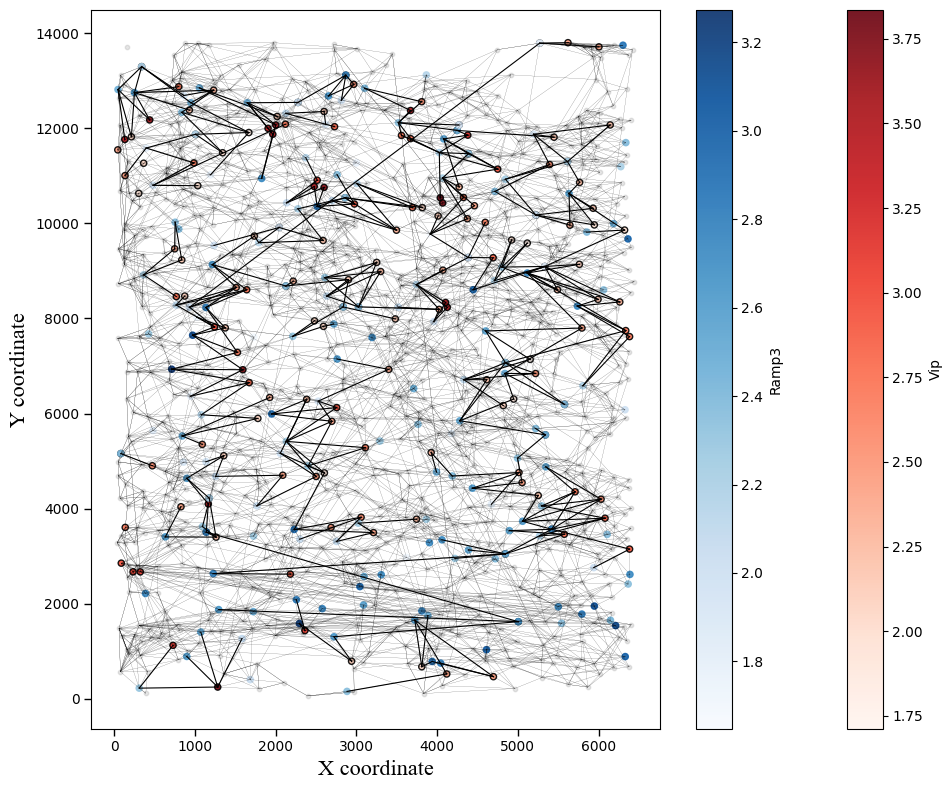

In [15]:
import pandas as pd
import numpy as np
count_df = starting_df.drop(columns=['Cell_ID', 'X', 'Y', 'Cell_Type'])
def filter_gene_expression(count_df, expression_threshold=1.0, min_cells=100):
    """
    筛选表达量大于给定阈值的基因，并确保基因在至少 min_cells 个细胞中表达。
    此外，排除负数的基因表达值。
    """
    # 仅保留大于 expression_threshold 的基因表达值（大于0的基因表达）
    valid_gene_expression = count_df > expression_threshold  # 只筛选大于阈值的表达

    # 计算每个基因满足条件的细胞数
    cells_above_threshold = valid_gene_expression.sum(axis=0)  # 统计每个基因大于阈值的细胞数
    
    # 筛选出在至少 min_cells 个细胞中满足条件的基因
    filtered_count_df = count_df.loc[:, cells_above_threshold >= min_cells]
    
    return filtered_count_df

# 对 count_df 进行筛选
filtered_count_df = filter_gene_expression(count_df)
print(filtered_count_df.head())

def get_valid_cells(count_df, gene1, gene2, selected_cells):
    # 确保 selected_cells 是整数类型的列表，并转换为索引对象
    if isinstance(selected_cells, list) and all(isinstance(i, int) for i in selected_cells):
        selected_cells_index = count_df.index[selected_cells]  # 获取对应的索引
    else:
        selected_cells_index = selected_cells  # 如果已经是一个合适的索引

    # 筛选出配体基因表达大于1的细胞
    valid_cells_gene1 = count_df.loc[selected_cells_index, gene1] > 1  # 配体基因表达大于1
    valid_cells_gene1_ids = selected_cells_index[valid_cells_gene1].tolist()  # 配体基因有效细胞ID
    
    # 筛选出受体基因表达大于1的细胞
    valid_cells_gene2 = count_df.loc[selected_cells_index, gene2] > 1  # 受体基因表达大于1
    valid_cells_gene2_ids = selected_cells_index[valid_cells_gene2].tolist()  # 受体基因有效细胞ID
    
    return valid_cells_gene1_ids, valid_cells_gene2_ids

# 示例：获取 'Gdf5' 和 'Bmpr1b' 筛选后的细胞ID
selected_cells = list(filtered_count_df.index)  # 假设这些是您的有效细胞列表
gene1 = 'Vip'  # 替换为实际的基因名
gene2 = 'Ramp3'  # 替换为实际的基因名

#ligand="Gal", receptor="Galr1",
valid_cells_gene1_ids, valid_cells_gene2_ids = get_valid_cells(filtered_count_df, gene1, gene2, selected_cells)

print(f"Valid cells for ligand gene {gene1}: {valid_cells_gene1_ids}")
print(f"Valid cells for receptor gene {gene2}: {valid_cells_gene2_ids}")

import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black',alpha=0.9,  label='Ligand Cells')
        fig.colorbar(scatter1, ax=ax, label=gene1)

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')
        fig.colorbar(scatter2, ax=ax, label=gene2)

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    #ax.set_title("Cell-level Graph with Colored Nodes", fontsize=24, family="Times New Roman")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)


    # 显示图表
    plt.tight_layout()
    plt.show()

fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Vip',  # 替换为实际的基因名
gene2 = 'Ramp3',  # 替换为实际的基因名

    figsize=(10, 8),
    markersize=20
)



In [63]:
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_celllevel_graph_with_colored_nodes(df, edge_trace=None, edge_weights=None, 
#                                                  selected_cells_1=None, selected_cells_2=None, 
#                                                  gene1=None, gene2=None, figsize=(10, 8), 
#                                                  markersize=10, xlim=None, ylim=None, publication=False):

#     fig, ax = plt.subplots(figsize=figsize)

#     # 获取 selected_cells_1 的 X 和 Y 坐标
#     selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
#     selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
#     selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
#     selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

#     # 绘制背景细胞（未选中的细胞）
#     all_cells = set(df.index)  
#     background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

#     if background_cells:
#         ax.scatter(df.loc[background_cells, 'X'], 
#                    df.loc[background_cells, 'Y'],
#                    s=10, color='gray', alpha=0.2, label="Background Cells")

#     # 绘制配体基因表达最强的细胞
#     if selected_cells_1 is not None and gene1 is not None:
#         gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
#         scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
#                               df.loc[selected_cells_1, 'Y'],
#                               s=markersize, c=gene1_values, cmap='Reds', edgecolors='black',alpha=0.9,  label='Ligand Cells')
#         fig.colorbar(scatter1, ax=ax, label=gene1)

#     # 绘制受体基因表达最强的细胞
#     if selected_cells_2 is not None and gene2 is not None:
#         gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
#         scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
#                               df.loc[selected_cells_2, 'Y'],
#                               s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')
#         fig.colorbar(scatter2, ax=ax, label=gene2)

#     # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
#     if edge_trace is not None:
#         edge_x, edge_y = edge_trace  # 解包坐标数据

#         # 遍历所有边的坐标，提取有效的坐标对
#         for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
#             x1, y1 = edge_x[i], edge_y[i]
#             x2, y2 = edge_x[i + 1], edge_y[i + 1]

#             # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
#             if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
#                 linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
#             else:
#                 linewidth = 0.1  # 默认边宽

#             # 绘制每一条边
#             ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

#     # 设置坐标轴限制
#     if xlim:
#         ax.set_xlim(xlim)
#     if ylim:
#         ax.set_ylim(ylim)

#     # 设置出版风格的布局
#     #ax.set_title("Cell-level Graph with Colored Nodes", fontsize=24, family="Times New Roman")
#     ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
#     ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
#     ax.tick_params(axis='both', which='both', length=5, width=1)


#     # 显示图表
#     plt.tight_layout()
#     plt.show()

# fig = visualize_celllevel_graph_with_colored_nodes(
#     df=starting_df, 
#     edge_trace=edges4,  # 边的坐标
#     edge_weights=combined_edge_weights,  # 边的权重
#     selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
#     selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
# gene1 = 'Vip',  # 替换为实际的基因名
# gene2 = 'Ramp3',  # 替换为实际的基因名

#     figsize=(10, 8),
#     markersize=20
# )



C:\Users\R9000\AppData\Local\Temp\ipykernel_33336\1837053350.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\R9000\AppData\Local\Temp\ipykernel_33336\1837053350.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


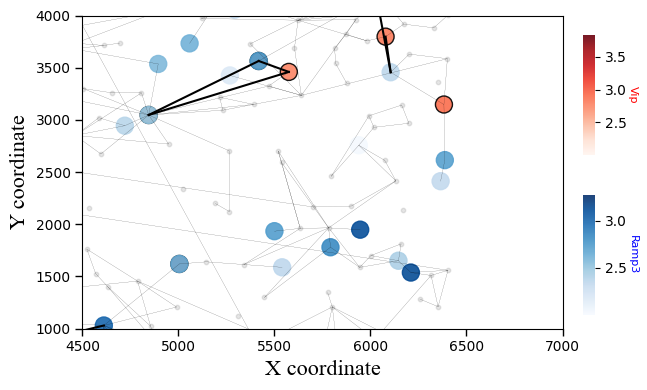

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes1(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False, save_path=None):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black', alpha=0.9, label='Ligand Cells')

        # Adjust colorbar for gene1
        cbar_ax1 = fig.add_axes([0.98, 0.6, 0.02, 0.3])  # Manually place the colorbar for gene1
        cbar1 = plt.colorbar(scatter1, cax=cbar_ax1)
        cbar1.set_label(gene1, color='red', rotation=270, labelpad=8, fontsize=8)
        cbar1.outline.set_visible(False)  # Hide the outline of the colorbar

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')

        # Adjust colorbar for gene2
        cbar_ax2 = fig.add_axes([0.98, 0.2, 0.02, 0.3])  # Manually place the colorbar for gene2
        cbar2 = plt.colorbar(scatter2, cax=cbar_ax2)
        cbar2.set_label(gene2, color='blue', rotation=270, labelpad=8, fontsize=8)
        cbar2.outline.set_visible(False)  # Hide the outline of the colorbar

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 1.5  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Save the plot to a file if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=900, bbox_inches='tight')

   # Optionally, close the figure to avoid it being displayed interactively
    plt.tight_layout()

    
    return fig

    # Call the function and save the plot
save_path = "Cell_Interaction_Graph.png"
fig = visualize_celllevel_graph_with_colored_nodes1(
        df=starting_df, 
        edge_trace=edges4,  # 边的坐标
        edge_weights=combined_edge_weights,  # 边的权重
        selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
        selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Vip',  # 替换为实际的基因名
gene2 = 'Ramp3',  # 替换为实际的基因名
        figsize=(6, 4),
        xlim=(4500, 7000),
        ylim=(1000,4000),
        markersize=150,
        save_path=save_path  # Provide save path to save the figure
    )


In [ ]:
配体列表 (lig_list): ['Sst', 'Sst', 'Sst', 'Sst', 'Sst', 'Agrp', 'Agrp', 'Agrp', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Oxt', 'Oxt', 'Sema3C', 'Sema3C', 'Sema3C', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Prok2', 'Prok2', 'Mfge8', 'Mfge8', 'Ptgs2', 'Ptgs2', 'Ptgs2', 'Rspo2', 'Nxph2', 'Reln', 'Bsg', 'Reln', 'Bsg', 'Spp1', 'Bsg', 'Vip', 'Sema3C', 'Apoe', 'Ptgs2', 'Tac1', 'Tac2', 'Rspo2', 'Apoe', 'Spp1', 'Reln', 'Mfge8', 'Reln', 'Trf', 'Apoe', 'Mfge8', 'Apoe', 'Sema3C', 'Bsg', 'Spp1', 'Cntn6', 'Reln', 'Spp1', 'Mfge8', 'Npy', 'Tac1', 'Tac2', 'Apoe', 'Trf', 'Tac1', 'Tac2', 'Apoe', 'Tac1', 'Apoe', 'Rspo2', 'Apoe', 'Spp1', 'Bsg', 'Rspo2', 'Bsg', 'Apoe', 'Bsg', 'Spp1', 'Apoe', 'Apoe', 'Spp1', 'Reln', 'Reln', 'Spp1', 'Apoe', 'Reln', 'Apoe', 'Sst', 'Vip', 'Bsg']
受体列表 (rec_list): ['Sstr2', 'Ramp3', 'Cav1']
    
符合条件的配体-受体对: [('Sst', 'Sstr2'), ('Vip', 'Ramp3'), ('Bsg', 'Cav1')]
    
    
    

   2810468N07Rik  3110035E14Rik     Acrbp    Acsbg1    Adarb2    Adgrl2  \
0      -0.385593      -0.748802 -0.396728  1.663570 -0.422765 -0.335642   
1       2.374186       1.081606 -0.396728 -0.638685 -0.422765 -0.335642   
2      -0.385593      -0.748802 -0.396728 -0.638685 -0.422765 -0.335642   
3      -0.385593      -0.748802 -0.396728 -0.638685 -0.422765  3.240607   
4      -0.385593       1.134736 -0.396728 -0.638685 -0.422765 -0.335642   

       Agrp      Aif1      Apod      Apoe  ...  Tmem258    Tmtc4     Trap1  \
0  2.076125 -0.316691 -0.793172  0.978978  ... -0.47595 -0.32761 -0.400978   
1 -0.578870 -0.316691 -0.793172 -1.229339  ... -0.47595 -0.32761  2.869831   
2 -0.578870 -0.316691 -0.793172  0.572672  ... -0.47595 -0.32761 -0.400978   
3 -0.578870 -0.316691  1.187635  1.069790  ... -0.47595 -0.32761 -0.400978   
4 -0.578870 -0.316691 -0.793172 -1.229339  ... -0.47595 -0.32761 -0.400978   

        Trf    Ube2e3      Ucma      Ucp2       Vip      Whrn    Ythdf2  
0  1.8

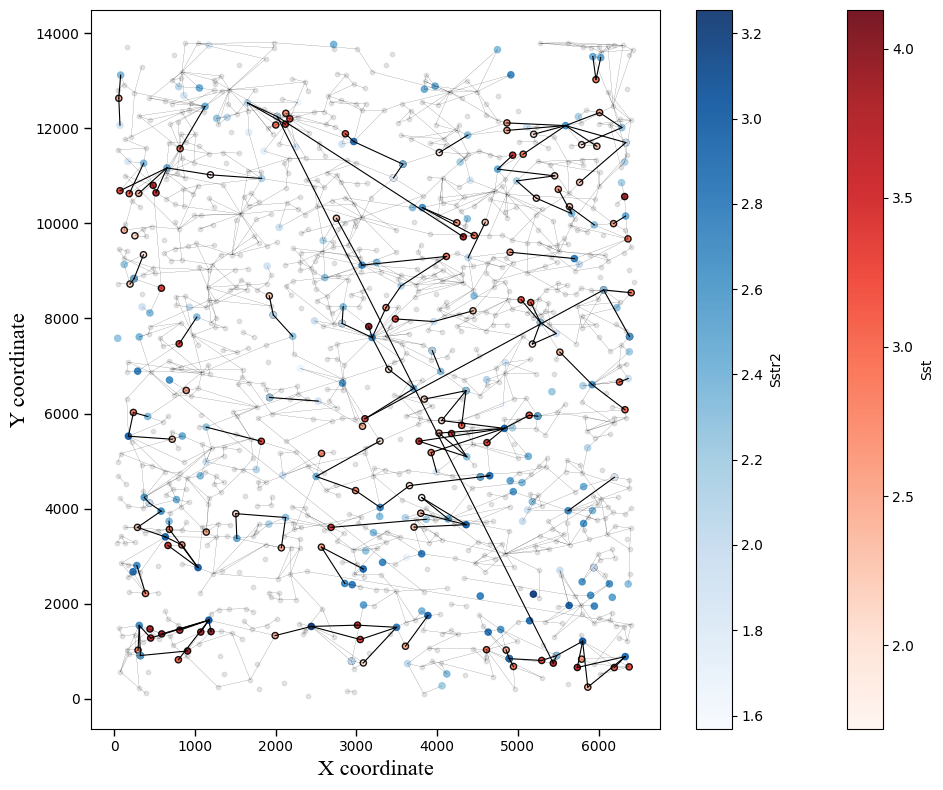

In [65]:
import pandas as pd
import numpy as np
count_df = starting_df.drop(columns=['Cell_ID', 'X', 'Y', 'Cell_Type'])
def filter_gene_expression(count_df, expression_threshold=0.5, min_cells=100):
    """
    筛选表达量大于给定阈值的基因，并确保基因在至少 min_cells 个细胞中表达。
    此外，排除负数的基因表达值。
    """
    # 仅保留大于 expression_threshold 的基因表达值（大于0的基因表达）
    valid_gene_expression = count_df > 0.5  # 只筛选大于阈值的表达

    # 计算每个基因满足条件的细胞数
    cells_above_threshold = valid_gene_expression.sum(axis=0)  # 统计每个基因大于阈值的细胞数
    
    # 筛选出在至少 min_cells 个细胞中满足条件的基因
    filtered_count_df = count_df.loc[:, cells_above_threshold >= min_cells]
    
    return filtered_count_df

# 对 count_df 进行筛选
filtered_count_df = filter_gene_expression(count_df)
print(filtered_count_df.head())

def get_valid_cells(count_df, gene1, gene2, selected_cells):
    # 确保 selected_cells 是整数类型的列表，并转换为索引对象
    if isinstance(selected_cells, list) and all(isinstance(i, int) for i in selected_cells):
        selected_cells_index = count_df.index[selected_cells]  # 获取对应的索引
    else:
        selected_cells_index = selected_cells  # 如果已经是一个合适的索引

    # 筛选出配体基因表达大于1的细胞
    valid_cells_gene1 = count_df.loc[selected_cells_index, gene1] > 1.2  # 配体基因表达大于1
    valid_cells_gene1_ids = selected_cells_index[valid_cells_gene1].tolist()  # 配体基因有效细胞ID
    
    # 筛选出受体基因表达大于1的细胞
    valid_cells_gene2 = count_df.loc[selected_cells_index, gene2] > 0.8  # 受体基因表达大于1
    valid_cells_gene2_ids = selected_cells_index[valid_cells_gene2].tolist()  # 受体基因有效细胞ID
    
    return valid_cells_gene1_ids, valid_cells_gene2_ids


selected_cells = list(filtered_count_df.index)  # 假设这些是您的有效细胞列表
gene1 = 'Sst'  # 替换为实际的基因名
gene2 = 'Sstr2'  # 替换为实际的基因名

valid_cells_gene1_ids, valid_cells_gene2_ids = get_valid_cells(filtered_count_df, gene1, gene2, selected_cells)


def visualize_celllevel_graph_with_colored_nodes(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black',alpha=0.9,  label='Ligand Cells')
        fig.colorbar(scatter1, ax=ax, label=gene1)

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')
        fig.colorbar(scatter2, ax=ax, label=gene2)

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    #ax.set_title("Cell-level Graph with Colored Nodes", fontsize=24, family="Times New Roman")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)


    # 显示图表
    plt.tight_layout()
    plt.show()

fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Sst',  # 替换为实际的基因名
gene2 = 'Sstr2',  # 替换为实际的基因名

    figsize=(10, 8),
    markersize=20
)



C:\Users\R9000\AppData\Local\Temp\ipykernel_33336\3397518482.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\R9000\AppData\Local\Temp\ipykernel_33336\3397518482.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


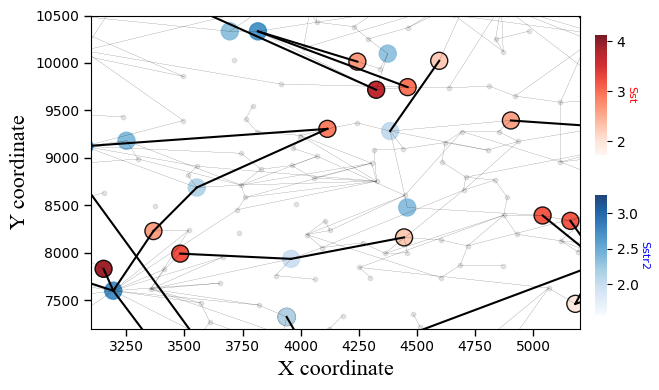

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes1(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False, save_path=None):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black', alpha=0.9, label='Ligand Cells')

        # Adjust colorbar for gene1
        cbar_ax1 = fig.add_axes([1, 0.6, 0.02, 0.3])  # Manually place the colorbar for gene1
        cbar1 = plt.colorbar(scatter1, cax=cbar_ax1)
        cbar1.set_label(gene1, color='red', rotation=270, labelpad=8, fontsize=8)
        cbar1.outline.set_visible(False)  # Hide the outline of the colorbar

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')

        # Adjust colorbar for gene2
        cbar_ax2 = fig.add_axes([1, 0.2, 0.02, 0.3])  # Manually place the colorbar for gene2
        cbar2 = plt.colorbar(scatter2, cax=cbar_ax2)
        cbar2.set_label(gene2, color='blue', rotation=270, labelpad=8, fontsize=8)
        cbar2.outline.set_visible(False)  # Hide the outline of the colorbar

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 1.5  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Save the plot to a file if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=900, bbox_inches='tight')

   # Optionally, close the figure to avoid it being displayed interactively
    plt.tight_layout()

    
    return fig

    # Call the function and save the plot
save_path = "Cell_Interaction_Graph.png"
fig = visualize_celllevel_graph_with_colored_nodes1(
        df=starting_df, 
        edge_trace=edges4,  # 边的坐标
        edge_weights=combined_edge_weights,  # 边的权重
        selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
        selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Sst',  # 替换为实际的基因名
gene2 = 'Sstr2',  # 替换为实际的基因名
        figsize=(6, 4),
        xlim=(3100, 5200),
        ylim=(7200,10500),
        markersize=150,
        save_path=save_path  # Provide save path to save the figure
    )


In [ ]:
配体列表 (lig_list): ['Sst', 'Sst', 'Sst', 'Sst', 'Sst', 'Agrp', 'Agrp', 'Agrp', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Oxt', 'Oxt', 'Sema3C', 'Sema3C', 'Sema3C', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Prok2', 'Prok2', 'Mfge8', 'Mfge8', 'Ptgs2', 'Ptgs2', 'Ptgs2', 'Rspo2', 'Nxph2', 'Reln', 'Bsg', 'Reln', 'Bsg', 'Spp1', 'Bsg', 'Vip', 'Sema3C', 'Apoe', 'Ptgs2', 'Tac1', 'Tac2', 'Rspo2', 'Apoe', 'Spp1', 'Reln', 'Mfge8', 'Reln', 'Trf', 'Apoe', 'Mfge8', 'Apoe', 'Sema3C', 'Bsg', 'Spp1', 'Cntn6', 'Reln', 'Spp1', 'Mfge8', 'Npy', 'Tac1', 'Tac2', 'Apoe', 'Trf', 'Tac1', 'Tac2', 'Apoe', 'Tac1', 'Apoe', 'Rspo2', 'Apoe', 'Spp1', 'Bsg', 'Rspo2', 'Bsg', 'Apoe', 'Bsg', 'Spp1', 'Apoe', 'Apoe', 'Spp1', 'Reln', 'Reln', 'Spp1', 'Apoe', 'Reln', 'Apoe', 'Sst', 'Vip', 'Bsg']
受体列表 (rec_list): ['Sstr2', 'Ramp3', 'Cav1']
    
符合条件的配体-受体对: [('Sst', 'Sstr2'), ('Vip', 'Ramp3'), ('Bsg', 'Cav1')]
    
    

   2810468N07Rik  3110035E14Rik     Acrbp    Acsbg1    Adarb2    Adgrl2  \
0      -0.385593      -0.748802 -0.396728  1.663570 -0.422765 -0.335642   
1       2.374186       1.081606 -0.396728 -0.638685 -0.422765 -0.335642   
2      -0.385593      -0.748802 -0.396728 -0.638685 -0.422765 -0.335642   
3      -0.385593      -0.748802 -0.396728 -0.638685 -0.422765  3.240607   
4      -0.385593       1.134736 -0.396728 -0.638685 -0.422765 -0.335642   

       Agrp      Aif1      Apod      Apoe  ...  Tmem258    Tmtc4     Trap1  \
0  2.076125 -0.316691 -0.793172  0.978978  ... -0.47595 -0.32761 -0.400978   
1 -0.578870 -0.316691 -0.793172 -1.229339  ... -0.47595 -0.32761  2.869831   
2 -0.578870 -0.316691 -0.793172  0.572672  ... -0.47595 -0.32761 -0.400978   
3 -0.578870 -0.316691  1.187635  1.069790  ... -0.47595 -0.32761 -0.400978   
4 -0.578870 -0.316691 -0.793172 -1.229339  ... -0.47595 -0.32761 -0.400978   

        Trf    Ube2e3      Ucma      Ucp2       Vip      Whrn    Ythdf2  
0  1.8

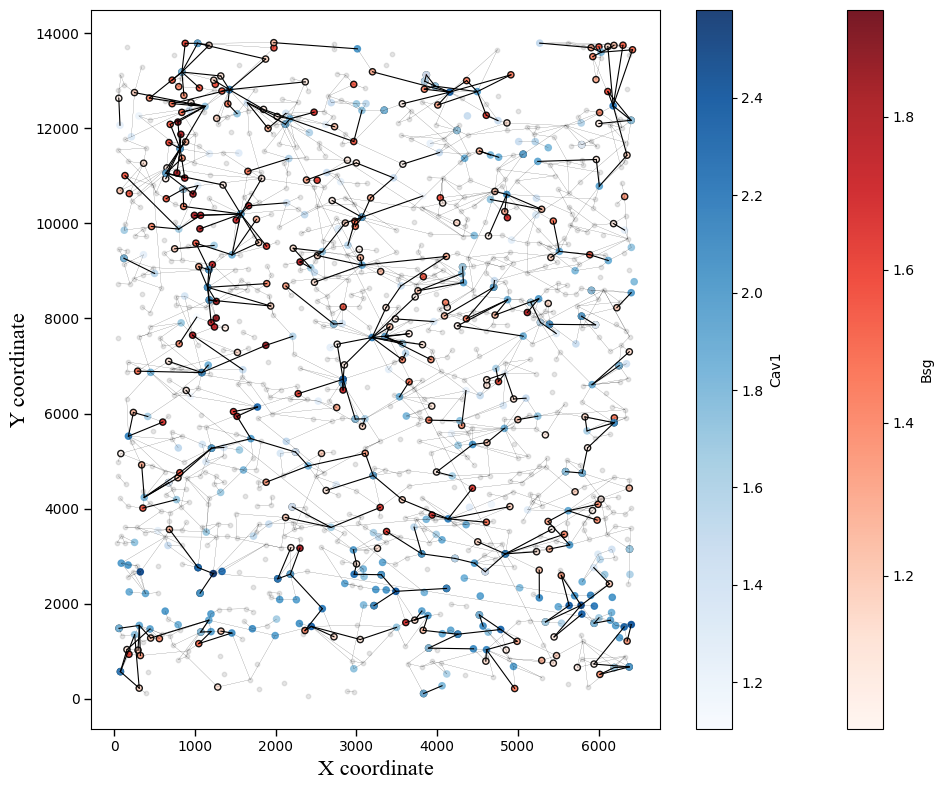

In [67]:
import pandas as pd
import numpy as np
count_df = starting_df.drop(columns=['Cell_ID', 'X', 'Y', 'Cell_Type'])
def filter_gene_expression(count_df, expression_threshold=1.0, min_cells=100):
    """
    筛选表达量大于给定阈值的基因，并确保基因在至少 min_cells 个细胞中表达。
    此外，排除负数的基因表达值。
    """
    # 仅保留大于 expression_threshold 的基因表达值（大于0的基因表达）
    valid_gene_expression = count_df > expression_threshold  # 只筛选大于阈值的表达

    # 计算每个基因满足条件的细胞数
    cells_above_threshold = valid_gene_expression.sum(axis=0)  # 统计每个基因大于阈值的细胞数
    
    # 筛选出在至少 min_cells 个细胞中满足条件的基因
    filtered_count_df = count_df.loc[:, cells_above_threshold >= min_cells]
    
    return filtered_count_df

# 对 count_df 进行筛选
filtered_count_df = filter_gene_expression(count_df)
print(filtered_count_df.head())

def get_valid_cells(count_df, gene1, gene2, selected_cells):
    # 确保 selected_cells 是整数类型的列表，并转换为索引对象
    if isinstance(selected_cells, list) and all(isinstance(i, int) for i in selected_cells):
        selected_cells_index = count_df.index[selected_cells]  # 获取对应的索引
    else:
        selected_cells_index = selected_cells  # 如果已经是一个合适的索引

    # 筛选出配体基因表达大于1的细胞
    valid_cells_gene1 = count_df.loc[selected_cells_index, gene1] > 1  # 配体基因表达大于1
    valid_cells_gene1_ids = selected_cells_index[valid_cells_gene1].tolist()  # 配体基因有效细胞ID
    
    # 筛选出受体基因表达大于1的细胞
    valid_cells_gene2 = count_df.loc[selected_cells_index, gene2] > 1.1  # 受体基因表达大于1
    valid_cells_gene2_ids = selected_cells_index[valid_cells_gene2].tolist()  # 受体基因有效细胞ID
    
    return valid_cells_gene1_ids, valid_cells_gene2_ids

# 示例：获取 'Gdf5' 和 'Bmpr1b' 筛选后的细胞ID
selected_cells = list(filtered_count_df.index)  # 假设这些是您的有效细胞列表
gene1 = 'Bsg'  # 替换为实际的基因名
gene2 = 'Cav1'  # 替换为实际的基因名

#ligand="Gal", receptor="Galr1",
valid_cells_gene1_ids, valid_cells_gene2_ids = get_valid_cells(filtered_count_df, gene1, gene2, selected_cells)


def visualize_celllevel_graph_with_colored_nodes(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black',alpha=0.9,  label='Ligand Cells')
        fig.colorbar(scatter1, ax=ax, label=gene1)

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')
        fig.colorbar(scatter2, ax=ax, label=gene2)

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    #ax.set_title("Cell-level Graph with Colored Nodes", fontsize=24, family="Times New Roman")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)


    # 显示图表
    plt.tight_layout()
    plt.show()

fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Bsg',  # 替换为实际的基因名
gene2 = 'Cav1',  # 替换为实际的基因名

    figsize=(10, 8),
    markersize=20
)



C:\Users\R9000\AppData\Local\Temp\ipykernel_33336\513337725.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\R9000\AppData\Local\Temp\ipykernel_33336\513337725.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


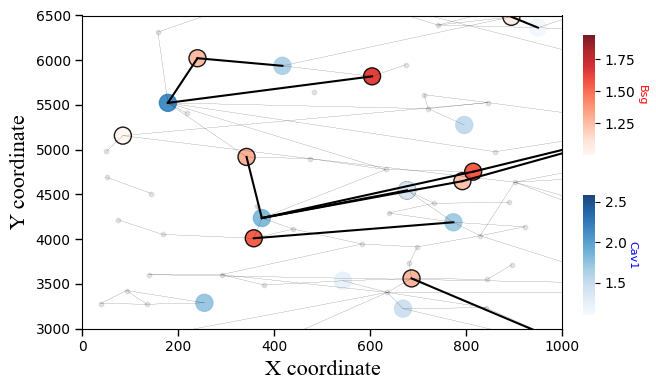

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes1(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False, save_path=None):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black', alpha=0.9, label='Ligand Cells')

        # Adjust colorbar for gene1
        cbar_ax1 = fig.add_axes([0.98, 0.6, 0.02, 0.3])  # Manually place the colorbar for gene1
        cbar1 = plt.colorbar(scatter1, cax=cbar_ax1)
        cbar1.set_label(gene1, color='red', rotation=270, labelpad=8, fontsize=8)
        cbar1.outline.set_visible(False)  # Hide the outline of the colorbar

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')

        # Adjust colorbar for gene2
        cbar_ax2 = fig.add_axes([0.98, 0.2, 0.02, 0.3])  # Manually place the colorbar for gene2
        cbar2 = plt.colorbar(scatter2, cax=cbar_ax2)
        cbar2.set_label(gene2, color='blue', rotation=270, labelpad=8, fontsize=8)
        cbar2.outline.set_visible(False)  # Hide the outline of the colorbar

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 1.5  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Save the plot to a file if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=900, bbox_inches='tight')

   # Optionally, close the figure to avoid it being displayed interactively
    plt.tight_layout()

    
    return fig

    # Call the function and save the plot
save_path = "Cell_Interaction_Graph.png"
fig = visualize_celllevel_graph_with_colored_nodes1(
        df=starting_df, 
        edge_trace=edges4,  # 边的坐标
        edge_weights=combined_edge_weights,  # 边的权重
        selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
        selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Bsg',  # 替换为实际的基因名
gene2 = 'Cav1',  # 替换为实际的基因名
        figsize=(6, 4),
        xlim=(0, 1000),
        ylim=(3000,6500),
        markersize=150,
        save_path=save_path  # Provide save path to save the figure
    )


In [ ]:
配体列表 (lig_list): ['Sst', 'Sst', 'Sst', 'Sst', 'Sst', 'Agrp', 'Agrp', 'Agrp', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Vip', 'Oxt', 'Oxt', 'Sema3C', 'Sema3C', 'Sema3C', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Npy', 'Prok2', 'Prok2', 'Mfge8', 'Mfge8', 'Ptgs2', 'Ptgs2', 'Ptgs2', 'Rspo2', 'Nxph2', 'Reln', 'Bsg', 'Reln', 'Bsg', 'Spp1', 'Bsg', 'Vip', 'Sema3C', 'Apoe', 'Ptgs2', 'Tac1', 'Tac2', 'Rspo2', 'Apoe', 'Spp1', 'Reln', 'Mfge8', 'Reln', 'Trf', 'Apoe', 'Mfge8', 'Apoe', 'Sema3C', 'Bsg', 'Spp1', 'Cntn6', 'Reln', 'Spp1', 'Mfge8', 'Npy', 'Tac1', 'Tac2', 'Apoe', 'Trf', 'Tac1', 'Tac2', 'Apoe', 'Tac1', 'Apoe', 'Rspo2', 'Apoe', 'Spp1', 'Bsg', 'Rspo2', 'Bsg', 'Apoe', 'Bsg', 'Spp1', 'Apoe', 'Apoe', 'Spp1', 'Reln', 'Reln', 'Spp1', 'Apoe', 'Reln', 'Apoe', 'Sst', 'Vip', 'Bsg']
受体列表 (rec_list): ['Sstr2', 'Ramp3', 'Cav1']
    
符合条件的配体-受体对: [('Sst', 'Sstr2'), ('Vip', 'Ramp3'), ('Bsg', 'Cav1')]
    
    

   2810468N07Rik  3110035E14Rik     Acrbp    Acsbg1    Adarb2    Adgrl2  \
0      -0.385593      -0.748802 -0.396728  1.663570 -0.422765 -0.335642   
1       2.374186       1.081606 -0.396728 -0.638685 -0.422765 -0.335642   
2      -0.385593      -0.748802 -0.396728 -0.638685 -0.422765 -0.335642   
3      -0.385593      -0.748802 -0.396728 -0.638685 -0.422765  3.240607   
4      -0.385593       1.134736 -0.396728 -0.638685 -0.422765 -0.335642   

       Agrp      Aif1      Apod      Apoe  ...  Tmem258    Tmtc4     Trap1  \
0  2.076125 -0.316691 -0.793172  0.978978  ... -0.47595 -0.32761 -0.400978   
1 -0.578870 -0.316691 -0.793172 -1.229339  ... -0.47595 -0.32761  2.869831   
2 -0.578870 -0.316691 -0.793172  0.572672  ... -0.47595 -0.32761 -0.400978   
3 -0.578870 -0.316691  1.187635  1.069790  ... -0.47595 -0.32761 -0.400978   
4 -0.578870 -0.316691 -0.793172 -1.229339  ... -0.47595 -0.32761 -0.400978   

        Trf    Ube2e3      Ucma      Ucp2       Vip      Whrn    Ythdf2  
0  1.8

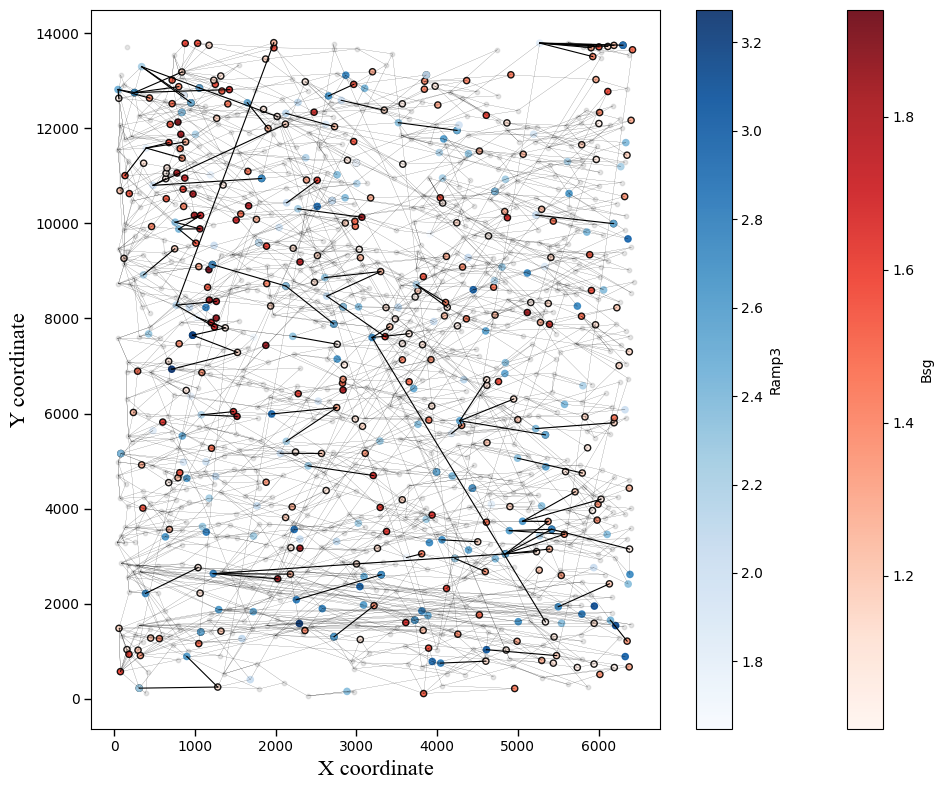

In [26]:
import pandas as pd
import numpy as np
count_df = starting_df.drop(columns=['Cell_ID', 'X', 'Y', 'Cell_Type'])
def filter_gene_expression(count_df, expression_threshold=1.0, min_cells=100):
    """
    筛选表达量大于给定阈值的基因，并确保基因在至少 min_cells 个细胞中表达。
    此外，排除负数的基因表达值。
    """
    # 仅保留大于 expression_threshold 的基因表达值（大于0的基因表达）
    valid_gene_expression = count_df > expression_threshold  # 只筛选大于阈值的表达

    # 计算每个基因满足条件的细胞数
    cells_above_threshold = valid_gene_expression.sum(axis=0)  # 统计每个基因大于阈值的细胞数
    
    # 筛选出在至少 min_cells 个细胞中满足条件的基因
    filtered_count_df = count_df.loc[:, cells_above_threshold >= min_cells]
    
    return filtered_count_df

# 对 count_df 进行筛选
filtered_count_df = filter_gene_expression(count_df)
print(filtered_count_df.head())

def get_valid_cells(count_df, gene1, gene2, selected_cells):
    # 确保 selected_cells 是整数类型的列表，并转换为索引对象
    if isinstance(selected_cells, list) and all(isinstance(i, int) for i in selected_cells):
        selected_cells_index = count_df.index[selected_cells]  # 获取对应的索引
    else:
        selected_cells_index = selected_cells  # 如果已经是一个合适的索引

    # 筛选出配体基因表达大于1的细胞
    valid_cells_gene1 = count_df.loc[selected_cells_index, gene1] > 1  # 配体基因表达大于1
    valid_cells_gene1_ids = selected_cells_index[valid_cells_gene1].tolist()  # 配体基因有效细胞ID
    
    # 筛选出受体基因表达大于1的细胞
    valid_cells_gene2 = count_df.loc[selected_cells_index, gene2] > 1  # 受体基因表达大于1
    valid_cells_gene2_ids = selected_cells_index[valid_cells_gene2].tolist()  # 受体基因有效细胞ID
    
    return valid_cells_gene1_ids, valid_cells_gene2_ids

# 示例：获取 'Gdf5' 和 'Bmpr1b' 筛选后的细胞ID
selected_cells = list(filtered_count_df.index)  # 假设这些是您的有效细胞列表
gene1 = 'Bsg'  # 替换为实际的基因名
gene2 = 'Ramp3'  # 替换为实际的基因名

#ligand="Gal", receptor="Galr1",
valid_cells_gene1_ids, valid_cells_gene2_ids = get_valid_cells(filtered_count_df, gene1, gene2, selected_cells)


def visualize_celllevel_graph_with_colored_nodes(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black',alpha=0.9,  label='Ligand Cells')
        fig.colorbar(scatter1, ax=ax, label=gene1)

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')
        fig.colorbar(scatter2, ax=ax, label=gene2)

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 0.8  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    #ax.set_title("Cell-level Graph with Colored Nodes", fontsize=24, family="Times New Roman")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)


    # 显示图表
    plt.tight_layout()
    plt.show()

fig = visualize_celllevel_graph_with_colored_nodes(
    df=starting_df, 
    edge_trace=edges4,  # 边的坐标
    edge_weights=combined_edge_weights,  # 边的权重
    selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
    selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Bsg',  # 替换为实际的基因名
gene2 = 'Ramp3',  # 替换为实际的基因名

    figsize=(10, 8),
    markersize=20
)



C:\Users\R9000\AppData\Local\Temp\ipykernel_10580\21142684.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\R9000\AppData\Local\Temp\ipykernel_10580\21142684.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


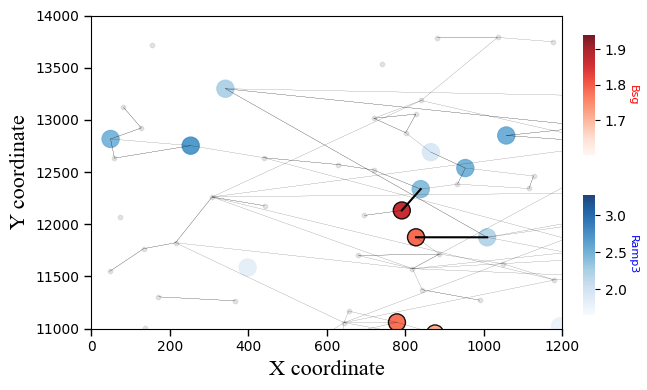

In [160]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_celllevel_graph_with_colored_nodes1(df, edge_trace=None, edge_weights=None, 
                                                 selected_cells_1=None, selected_cells_2=None, 
                                                 gene1=None, gene2=None, figsize=(10, 8), 
                                                 markersize=10, xlim=None, ylim=None, publication=False, save_path=None):

    fig, ax = plt.subplots(figsize=figsize)

    # 获取 selected_cells_1 的 X 和 Y 坐标
    selected_cells_1_x = df.loc[selected_cells_1, 'X'].values
    selected_cells_1_y = df.loc[selected_cells_1, 'Y'].values
    selected_cells_2_x = df.loc[selected_cells_2, 'X'].values
    selected_cells_2_y = df.loc[selected_cells_2, 'Y'].values

    # 绘制背景细胞（未选中的细胞）
    all_cells = set(df.index)  
    background_cells = list(all_cells - set(selected_cells_1) - set(selected_cells_2))

    if background_cells:
        ax.scatter(df.loc[background_cells, 'X'], 
                   df.loc[background_cells, 'Y'],
                   s=10, color='gray', alpha=0.2, label="Background Cells")

    # 绘制配体基因表达最强的细胞
    if selected_cells_1 is not None and gene1 is not None:
        gene1_values = np.array(df.loc[selected_cells_1, gene1].values)
        scatter1 = ax.scatter(df.loc[selected_cells_1, 'X'], 
                              df.loc[selected_cells_1, 'Y'],
                              s=markersize, c=gene1_values, cmap='Reds', edgecolors='black', alpha=0.9, label='Ligand Cells')

        # Adjust colorbar for gene1
        cbar_ax1 = fig.add_axes([0.98, 0.6, 0.02, 0.3])  # Manually place the colorbar for gene1
        cbar1 = plt.colorbar(scatter1, cax=cbar_ax1)
        cbar1.set_label(gene1, color='red', rotation=270, labelpad=8, fontsize=8)
        cbar1.outline.set_visible(False)  # Hide the outline of the colorbar

    # 绘制受体基因表达最强的细胞
    if selected_cells_2 is not None and gene2 is not None:
        gene2_values = np.array(df.loc[selected_cells_2, gene2].values)
        scatter2 = ax.scatter(df.loc[selected_cells_2, 'X'], 
                              df.loc[selected_cells_2, 'Y'],
                              s=markersize, c=gene2_values, cmap='Blues', alpha=0.9, label='Receptor Cells')

        # Adjust colorbar for gene2
        cbar_ax2 = fig.add_axes([0.98, 0.2, 0.02, 0.3])  # Manually place the colorbar for gene2
        cbar2 = plt.colorbar(scatter2, cax=cbar_ax2)
        cbar2.set_label(gene2, color='blue', rotation=270, labelpad=8, fontsize=8)
        cbar2.outline.set_visible(False)  # Hide the outline of the colorbar

    # 清理 edge_trace 数据，提取有效的 edge_x 和 edge_y
    if edge_trace is not None:
        edge_x, edge_y = edge_trace  # 解包坐标数据

        # 遍历所有边的坐标，提取有效的坐标对
        for i in range(0, len(edge_x) - 1, 2):  # 确保不会超出范围
            x1, y1 = edge_x[i], edge_y[i]
            x2, y2 = edge_x[i + 1], edge_y[i + 1]

            # 检查每个端点是否在 selected_cells_1 和 selected_cells_2 中
            if (x1 in selected_cells_1_x and y1 in selected_cells_1_y) and (x2 in selected_cells_2_x and y2 in selected_cells_2_y):
                linewidth = 01.5  # 如果两端点都在 selected_cells_1 和 selected_cells_2 中，加粗边
            else:
                linewidth = 0.1  # 默认边宽

            # 绘制每一条边
            ax.plot([x1, x2], [y1, y2], color='black', lw=linewidth)

    # 设置坐标轴限制
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

    # 设置出版风格的布局
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")
    ax.tick_params(axis='both', which='both', length=5, width=1)

    # Save the plot to a file if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=900, bbox_inches='tight')

   # Optionally, close the figure to avoid it being displayed interactively
    plt.tight_layout()

    
    return fig

    # Call the function and save the plot
save_path = "Cell_Interaction_Graph.png"
fig = visualize_celllevel_graph_with_colored_nodes1(
        df=starting_df, 
        edge_trace=edges4,  # 边的坐标
        edge_weights=combined_edge_weights,  # 边的权重
        selected_cells_1=valid_cells_gene1_ids,  # 配体基因的细胞ID
        selected_cells_2=valid_cells_gene2_ids,  # 受体基因的细胞ID
gene1 = 'Bsg',  # 替换为实际的基因名
gene2 = 'Ramp3',  # 替换为实际的基因名
        figsize=(6, 4),
        xlim=(0, 1200),
        ylim=(11000,14000),
        markersize=150,
        save_path=save_path  # Provide save path to save the figure
    )


Output()

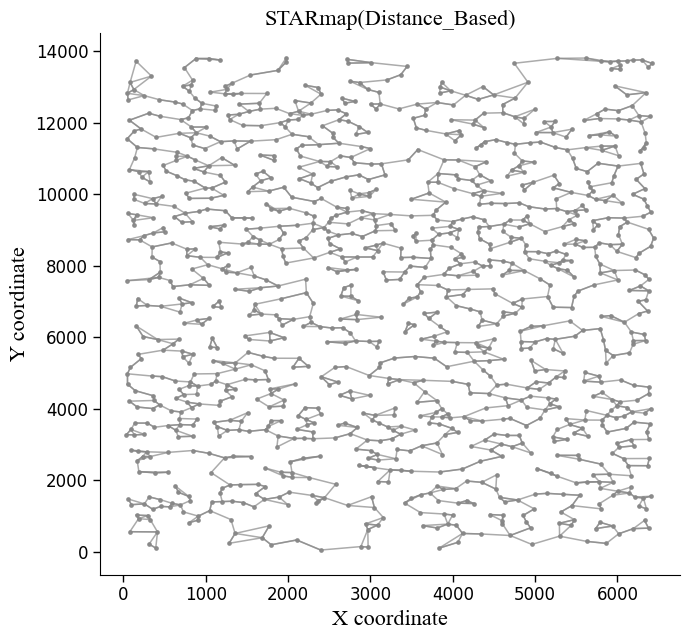

In [12]:
import matplotlib.pyplot as plt
import numpy as np

from rich.progress import track
def construct_celllevel_graph(data_df, k, get_edges=False):   # Top k closest neighbors for each cell
    '''
    Constructs new cell graph with spatial proximity edges based on kNN.
    
    :data_df: pd.DataFrame : represents the spatial data and contains the following columns ["Cell_ID", "X", "Y"]
    :k: int: Number of nearest neighbors to construct spatial edges for
    :get_edges: boolean:  True to return edge_trace (for visualization purposes)
    
    :return: Cell_level_adjacency, edge list
    '''
    
    adjacency = np.zeros(shape=(len(data_df), k),dtype=int) # shape = (numcells, numneighbors of cell)
    coords = np.vstack([data_df["X"].values,data_df["Y"].values]).T

    edges = None
    edge_x = []
    edge_y = []

    # for i in tqdm(range(len(data_df)), desc=f"2. Constructing Cell-Level Graph from ST Data", colour="cyan", position=1):
    for i in track(range(len(data_df)), description=f"[cyan]2. Constructing Cell-Level Graph from ST Data"):
        cell_id = data_df["Cell_ID"][i]
        x0, y0 = data_df["X"].values[i],data_df["Y"].values[i]
        candidate_cell = coords[i]
        candidate_neighbors = coords
        euclidean_distances = np.linalg.norm(candidate_neighbors - candidate_cell,axis=1)
        neighbors = np.argsort(euclidean_distances)[1:k+1]
        adjacency[i] = neighbors
        assert i not in adjacency[i]
        if get_edges:
            for ncell in adjacency[i]:
                x1, y1 = data_df["X"].values[ncell],data_df["Y"].values[ncell]
                edge_x.append(x0)
                edge_x.append(x1)
                #edge_x.append(None)
                edge_y.append(y0)
                edge_y.append(y1)
                #edge_y.append(None)
        
    edges=[edge_x,edge_y]
                
    return adjacency,edges
celllevel_adj, edges = construct_celllevel_graph(
    starting_df, k=2, get_edges=True
)
import plotly.graph_objects as go
import numpy as np
import plotly.express as px



# Enable interactive mode
plt.ion()

def visualize_celllevel_graph(df, title, edge_trace=None, edge_weights=1, publication=False):
    # Convert pixels to inches (for 100 DPI, 700px becomes 7 inches, 650px becomes 6.5 inches)
    figsize_in_inches = (700 / 100, 650 / 100)  # 700x650 pixels at 100 DPI
    
    # 创建一个新图形，设置大小为700x650像素（100 DPI）
    fig, ax = plt.subplots(figsize=figsize_in_inches)

    # 绘制细胞散点图，所有点的颜色统一为灰色
    ax.scatter(df["X"], df["Y"], color="gray", s=6, alpha=0.8, label="Cells")

    # 如果有边的坐标信息，添加边的描绘
    if edge_trace is not None:
        for i in range(0, len(edge_trace[0]), 2):
            x0, y0 = edge_trace[0][i], edge_trace[1][i]
            x1, y1 = edge_trace[0][i+1], edge_trace[1][i+1]
            ax.plot([x0, x1], [y0, y1], color='#888', lw=1.1, alpha=0.7)

    # 设置标题
    ax.set_title(title, fontsize=16, family="Times New Roman", color="black")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")

    # 设置坐标轴样式
    ax.tick_params(axis='both', which='both', length=5, width=1, labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 设置出版风格的布局（清晰的白色背景，简洁的线条，去除不必要的元素）
    if not publication:
        ax.grid(False)  # 隐藏网格线

    # 如果需要出版风格，设置白色背景和没有图例
    else:
        ax.set_facecolor("white")
        ax.legend().set_visible(False)

    # 保存图像，增加DPI以提高分辨率
    plt.tight_layout()  # 自动调整布局
    plt.savefig("Cell_Interaction(Distance_based)_seq.png", dpi=300, bbox_inches='tight')  # 保存为高分辨率图像

    # 显示图形
    plt.show()

    return fig

sim_fig = visualize_celllevel_graph(
    starting_df, title="STARmap(Distance_Based)", edge_trace=edges,
)


边的坐标长度: 4000
边的坐标长度: 4000


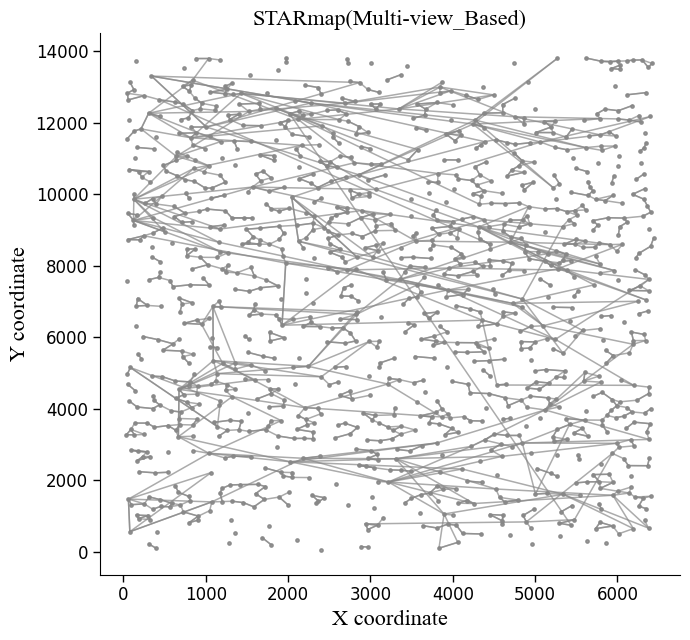

In [44]:
# Enable interactive mode
plt.ion()

def visualize_celllevel_graph(df, title, edge_trace=None, edge_weights=1, publication=False):
    # Convert pixels to inches (for 100 DPI, 700px becomes 7 inches, 650px becomes 6.5 inches)
    figsize_in_inches = (700 / 100, 650 / 100)  # 700x650 pixels at 100 DPI
    
    # 创建一个新图形，设置大小为700x650像素（100 DPI）
    fig, ax = plt.subplots(figsize=figsize_in_inches)

    # 绘制细胞散点图，所有点的颜色统一为灰色
    ax.scatter(df["X"], df["Y"], color="gray", s=6, alpha=0.8, label="Cells")

    # 如果有边的坐标信息，添加边的描绘
    if edge_trace is not None:
        for i in range(0, len(edge_trace[0]), 2):
            x0, y0 = edge_trace[0][i], edge_trace[1][i]
            x1, y1 = edge_trace[0][i+1], edge_trace[1][i+1]
            ax.plot([x0, x1], [y0, y1], color='#888', lw=1.1, alpha=0.7)

    # 设置标题
    ax.set_title(title, fontsize=16, family="Times New Roman", color="black")
    ax.set_xlabel("X coordinate", fontsize=16, family="Times New Roman")
    ax.set_ylabel("Y coordinate", fontsize=16, family="Times New Roman")

    # 设置坐标轴样式
    ax.tick_params(axis='both', which='both', length=5, width=1, labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 设置出版风格的布局（清晰的白色背景，简洁的线条，去除不必要的元素）
    if not publication:
        ax.grid(False)  # 隐藏网格线

    # 如果需要出版风格，设置白色背景和没有图例
    else:
        ax.set_facecolor("white")
        ax.legend().set_visible(False)

    # 保存图像，增加DPI以提高分辨率
    plt.tight_layout()  # 自动调整布局
    plt.savefig("STARmap(Multi_view).png", dpi=300, bbox_inches='tight')  # 保存为高分辨率图像

    # 显示图形
    plt.show()

    return fig
print(f"边的坐标长度: {len(edges4[0])}")
print(f"边的坐标长度: {len(edges4[1])}")

sim_fig = visualize_celllevel_graph(
    starting_df, title="STARmap(Multi-view_Based)", edge_trace=edges4,
)


In [86]:
celllevel_adj4

array([[   8,   67,    5, ...,    0,    0,    0],
       [  41,   51,    0, ...,    0,    0,    0],
       [ 199,   40,  172, ...,    0,    0,    0],
       ...,
       [1186, 1178, 1085, ...,    0,    0,    0],
       [1121, 1060, 1192, ...,    0,    0,    0],
       [1156, 1127, 1196, ...,    0,    0,    0]])

In [87]:
import numpy as np

def convert_adjacencylist2edgelist(adj_list):
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, num_edges))
    '''
    
    edge_list = []
    
    # Iterate through the adjacency list
    for node, neighbors in enumerate(adj_list):
        # Only add edges where the neighbor is non-zero
        for neighbor in neighbors:
            if neighbor != 0:  # Exclude zero entries (no edge)
                edge_list.append([node, neighbor])
    
    return np.array(edge_list).T

# Example usage:
celllevel_edgelist4 = convert_adjacencylist2edgelist(celllevel_adj4)


In [91]:
import numpy as np

def convert_adjacencylist2edgelist(adj_list):
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, num_edges))
    '''
    
    edge_list = []
    
    # Iterate through the adjacency list
    for node, neighbors in enumerate(adj_list):
        # Only add edges where the neighbor is non-zero
        for neighbor in neighbors:
            if neighbor != 0:  # Exclude zero entries (no edge)
                edge_list.append([node, neighbor])
    
    return np.array(edge_list).T

###########
celllevel_edgelist4 = convert_adjacencylist2edgelist(celllevel_adj4)
assert celllevel_edgelist4.shape == (2, celllevel_adj4.shape[0] * celllevel_adj4.shape[1])

AssertionError: 

In [90]:
celllevel_edgelist4.shape
assert celllevel_edgelist4.shape == (2, celllevel_adj4.shape[0] * celllevel_adj4.shape[1])

AssertionError: 

In [180]:
def convert_adjacencylist2edgelist(adj_list): # do we need to account for repeat edges?
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array(shape=(numnodes, numneighbors)) : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    edge_list = []
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            edge_list.append([node, neighbor])
            
    return np.array(edge_list).T
celllevel_edgelist1 =convert_adjacencylist2edgelist(celllevel_adj1)
assert celllevel_edgelist1.shape == (2, celllevel_adj1.shape[0] * celllevel_adj1.shape[1])
##############
celllevel_edgelist2 =convert_adjacencylist2edgelist(celllevel_adj2)
assert celllevel_edgelist2.shape == (2, celllevel_adj2.shape[0] * celllevel_adj2.shape[1])
##############
#celllevel_edgelist3 =convert_adjacencylist2edgelist(celllevel_adj3)
#assert celllevel_edgelist3.shape == (2, celllevel_adj3.shape[0] * celllevel_adj3.shape[1])
###########
#celllevel_edgelist4 = convert_adjacencylist2edgelist(celllevel_adj4)
#assert celllevel_edgelist4.shape == (2, celllevel_adj4.shape[0] * celllevel_adj4.shape[1])

def convert_adjacencylist2adjacencymatrix(adj_list):
    
    num_vertices = len(adj_list)
    adj_matrix = np.zeros(shape=(num_vertices,num_vertices))
     
    for i in range(num_vertices):
        for j in adj_list[i]:
            adj_matrix[i][j] = 1
            adj_matrix[j][i] = 1
     
    return adj_matrix

import os

preprocess_output_path = ".new2"

if not os.path.exists(preprocess_output_path):
    os.makedirs(preprocess_output_path)
    print(f"路径 {preprocess_output_path} 创建成功！")
else:
    print(f"路径 {preprocess_output_path} 已经存在。")
# 保存邻接矩阵和边列表（从1到4）
for i in range(1, 3):  # 从1到4
    # 假设你有celllevel_adj和celllevel_edgelist数据
    adj_matrix = convert_adjacencylist2adjacencymatrix(globals()[f'celllevel_adj{i}'])  # 动态获取celllevel_adj1, celllevel_adj2, ...
    np.save(os.path.join(preprocess_output_path, f"celllevel_adjacencymatrix{i}.npy"), adj_matrix)
    print(f"Adjacency matrix saved to {os.path.join(preprocess_output_path, f'celllevel_adjacencymatrix{i}.npy')}")
    
    np.save(os.path.join(preprocess_output_path, f"celllevel_edgelist{i}.npy"), globals()[f'celllevel_edgelist{i}'])  # 动态获取celllevel_edgelist1, celllevel_edgelist2, ...
    print(f"Edge list saved to {os.path.join(preprocess_output_path, f'celllevel_edgelist{i}.npy')}")
    
    


路径 .new2 已经存在。
Adjacency matrix saved to .new2\celllevel_adjacencymatrix1.npy
Edge list saved to .new2\celllevel_edgelist1.npy
Adjacency matrix saved to .new2\celllevel_adjacencymatrix2.npy
Edge list saved to .new2\celllevel_edgelist2.npy


In [ ]:
unique_edges

In [51]:
import numpy as np
import scipy.sparse as sp

def convert_adjacencylist2edgelist(adj_list):
    '''
    Converts adjacency list to edge list format for pytorch geometric processing.
    
    :adj_list: nd.array or sparse matrix : adjacency list representation
    
    :return: nd.array(shape=(2, numnodes * numneighbors))
    '''
    
    # 如果是稀疏矩阵，转化为密集矩阵
    if sp.issparse(adj_list):
        adj_list = adj_list.toarray()  # 转为密集矩阵
    
    edge_list = set()  # 使用集合去重，避免重复边
    
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            if neighbor != 0:  # 忽略没有连接的节点（即邻接矩阵中的零）
                # 无向图边去重：将边按字典序排序，保证每条边的顺序一致
                edge = tuple(sorted([node, neighbor]))
                edge_list.add(edge)  # 将边添加到集合中，集合会自动去重
            
    # 转换为numpy数组，并转置为 [2, N] 的形式
    edge_array = np.array(list(edge_list)).T
    return edge_array


# 对于 celllevel_edgelist2，计算实际的有效边数量
celllevel_edgelist2 = convert_adjacencylist2edgelist(celllevel_adj2)
num_edges2 = len(celllevel_edgelist2[0])

# 调整断言，依据实际有效边数进行比较
assert celllevel_edgelist2.shape == (2, num_edges2)


In [50]:
def convert_adjacencylist2adjacencymatrix(adj_list):
    
    num_vertices = len(adj_list)
    adj_matrix = np.zeros(shape=(num_vertices,num_vertices))
     
    for i in range(num_vertices):
        for j in adj_list[i]:
            adj_matrix[i][j] = 1
            adj_matrix[j][i] = 1
     
    return adj_matrix
a = convert_adjacencylist2adjacencymatrix(unique_edges)

IndexError: index 246 is out of bounds for axis 0 with size 2

In [22]:
celllevel_edgelist4

array([[   0,    0,    0, ..., 1206, 1206, 1206],
       [   8,    0,    0, ...,    0,    0,    0]])

In [99]:
celllevel_edgelist4.shape

(2, 2414)

In [100]:
edge_list = np.load('.4\celllevel_edgelist4.npy')

# 查看文件内容
print(edge_list)

[[   0    0    1 ... 1205 1206 1206]
 [   8    0   41 ... 1143    0    0]]


In [61]:
edge_list.shape

(2, 2414)